# Compare ATL06-SR/ASO Pairs  
There are 8 pairs of ATL06-SR and ASO data that were acquired within 20 days of each other. In this notebook we compare statistics between pairs, and calculate median differences and RMSEs as total pair statistics. 

### Load necessary packages:

In [38]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
import datetime
from rasterstats import zonal_stats
import pickle

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '13'

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def iqr(x):
    IQR = scipy.stats.iqr(x, interpolation = 'midpoint', nan_policy='omit')
    return IQR

### Make lists of dates for ASO and ICESat-2 data acquisition pairs:

In [6]:
aso_fn_winters = ['../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190324_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190417_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190503_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_snowdepth_3m_20200413_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_snowdepth_3m_20200522_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_50m_20210225_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220204_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220405_20m.tif']

In [7]:
 atl06_dates = [datetime.date(2019, 3, 12), 
              datetime.date(2019, 4, 10),
              datetime.date(2019, 5, 14),
              datetime.date(2020, 4, 7),
              datetime.date(2020, 6, 8),
              datetime.date(2021, 2, 8),
              datetime.date(2022, 2, 6),
              datetime.date(2022, 4, 3)]

In [8]:
aso_date_list = []
for fn in aso_fn_winters:
    date_string = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[-2]
    date = datetime.datetime.strptime(date_string, "%Y%m%d").date()
    aso_date_list.append(date)

In [9]:
print('aso length:', len(aso_date_list))
print('atl06sr length:', len(atl06_dates))

aso length: 8
atl06sr length: 8


In [11]:
# # written by Hannah Besso, June 30, 2022

# def build_stats(rasterstats):
#     rasterstats = rasterstats[0]
#     stats_dict = {'mean':rasterstats['mean'], 'iqr':(rasterstats['max']-rasterstats['min']), 'whishi':rasterstats['max'], 'whislo':rasterstats['min'], 'q1':rasterstats['percentile_25'], 'med':rasterstats['median'], 'q3':rasterstats['percentile_75'], 'count':rasterstats['count']}
#     return stats_dict

# def build_bp_stats(raster_list = None, region = None):
#     dict_list = []
#     pos = []
#     count = []
#     for file in raster_list:
#         rasterstats = zonal_stats(region, file, nodata=(-999), stats="mean min max median percentile_25 percentile_75 count")
#         stats_dict = build_stats(rasterstats)
#         dict_list.append(stats_dict)
#         date = os.path.splitext(os.path.split(file)[-1])[0].split('_')[-2]
#         pos.append((pd.to_datetime(date) - pd.to_datetime(mpl_epoch)).days)
#         count.append(stats_dict['count'])

#     count = np.array(count)
#     return dict_list, pos, count

### Load in the required data:

In [10]:
# ATL06-SlideRule data:
atl06sr_gdf = pickle.load(open('../../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl', 'rb'))

# outline of the study area:
outline_gdf = pickle.load(open('../../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))

# Reverse outline polygon for plotting:
tuol_reverse = pickle.load(open('../../../data/misc/tuol_reverse.pkl', 'rb'))

# Daily CDEC snow depth data:
snwd = pickle.load(open('../../data/CDEC/cdec_gdf.pkl', 'rb'))

# Geospatial information for the 2 CDEC stations:
cdec_geom = pickle.load(open('../../data/CDEC/cdec_geometries.pkl', 'rb'))

# Temporal information about ASO data acquisition dates for determining pairs:
aso_gdf = pickle.load(open('../../../data/misc/aso_dates.pkl', 'rb'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6827/1569761182.py:2: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  atl06sr_gdf = pickle.load(open('../../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6827/1569761182.py:5: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  outline_gdf = pickle.load(open('../../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6827/1569761182.py:8: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  tuol_reverse = pickle.load(open('../../../data/misc/tuol_reverse.pkl', 'rb'))
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel

### Remove outliers using a z-score filter and absolute value filter:

In [11]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['diff_plus_bicubic'] - atl06sr_gdf['diff_plus_bicubic'].mean()) / atl06sr_gdf['diff_plus_bicubic'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [12]:
atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) #& (atl06sr_gdf['diff_plus_bicubic'].abs() <= absdiff_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

In [13]:
atl06sr_gdf_inner = atl06sr_gdf[atl06_idx]

### Write functions for calculating statistics between pairs:

In [14]:
# written by Hannah Besso, Oct 14, 2022
# Calculates statistics for ASO snow depth data sets across the entire study site

def build_basin_df(raster_list = None, region = None):
    stats_df = pd.DataFrame()
    for file in raster_list:
        rasterstats = zonal_stats(region, file, nodata=(-9999.0), 
                                  stats="mean min max median percentile_25 percentile_75 count std")
        rasterstats[0]['iqr'] = rasterstats[0]['percentile_75'] - rasterstats[0]['percentile_25']
        date = os.path.splitext(os.path.split(file)[-1])[0].split('_')[-2]
        date2 = pd.to_datetime(date)
        stats_df = pd.concat([stats_df, pd.DataFrame(rasterstats[0], index=[date2])])
    stats_df['acqdate'] = stats_df.index.date
    return stats_df

In [15]:
#

def make_pairs_table(df):
    comp_table = pd.DataFrame()
    comp_table.index = pd.DatetimeIndex(data=sorted(atl06_dates + aso_date_list))
    comp_table['acqdate'] = comp_table.index.date
    comp_table['ATL06SR'] = np.nan
    comp_table.loc[comp_table['acqdate'].isin(atl06_dates),'ATL06SR'] = True
    comp_table.loc[comp_table['acqdate'].isin(aso_date_list),'ATL06SR'] = False
    comp_table['ASO'] = np.nan
    comp_table.loc[comp_table['acqdate'].isin(atl06_dates),'ASO'] = False
    comp_table.loc[comp_table['acqdate'].isin(aso_date_list),'ASO'] = True

    comp_table['pair'] = ''
    for i in range(len(comp_table)):
        comp_table.iloc[i:i+1, 3] = int(i/2)

    comp_table['median'] = np.nan
    for date in atl06_dates:
        comp_table.loc[comp_table['acqdate']==date, 'median'] = np.nanmedian(df.loc[df['acqdate']==date,'diff_plus_bicubic'])
    for date in aso_date_list:
        comp_table.loc[comp_table['acqdate']==date, 'median'] = np.nanmedian(df.loc[df['ASO_snowon_date']==date,'ASO_snowon_bic'])

    comp_table['median_diff'] = ''
    for i in comp_table['pair'].unique():
        x = np.diff(comp_table[comp_table['pair']==i]['median'])
        comp_table.loc[comp_table['pair']==i, 'median_diff'] = x[0]    
    
    # As per Jeff Dozier:
    comp_table['rmse'] = np.nan
    for date in atl06_dates:
        squared_dif = (df.loc[df['acqdate']==date, 'diff_plus_bicubic'] - df.loc[df['acqdate']==date, 'ASO_snowon_bic'])**2
        comp_table.loc[comp_table['acqdate']==date, 'rmse'] = np.sqrt(np.nansum(squared_dif/np.count_nonzero(~np.isnan(squared_dif))))
        
    comp_table['mae'] = np.nan
    for date in atl06_dates:
        abs_dif_sum = np.nansum(abs(df.loc[df['acqdate']==date, 'diff_plus_bicubic'] - df.loc[df['acqdate']==date, 'ASO_snowon_bic']))
        n = np.count_nonzero(~np.isnan(abs(df.loc[df['acqdate']==date, 'diff_plus_bicubic'] - df.loc[df['acqdate']==date, 'ASO_snowon_bic'])))
        comp_table.loc[comp_table['acqdate']==date, 'mae'] = abs_dif_sum/n
            
    comp_table['iqr'] = np.nan
    for date in atl06_dates:
        comp_table.loc[comp_table['acqdate']==date, 'iqr'] = iqr(df.loc[df['acqdate']==date,'diff_plus_bicubic'])
    for date in aso_date_list:
        comp_table.loc[comp_table['acqdate']==date, 'iqr'] = iqr(df.loc[df['ASO_snowon_date']==date,'ASO_snowon_bic'])

    comp_table['stdev'] = np.nan
    for date in atl06_dates:
        comp_table.loc[comp_table['acqdate']==date, 'stdev'] = np.std(df.loc[df['acqdate']==date,'diff_plus_bicubic'])
    for date in aso_date_list:
        comp_table.loc[comp_table['acqdate']==date, 'stdev'] = np.std(df.loc[df['ASO_snowon_date']==date,'ASO_snowon_bic'])
    
    comp_table['iqr_diff'] = np.nan
    for i in comp_table['pair'].unique():
        x = np.diff(comp_table[comp_table['pair']==i]['iqr'])
        comp_table.loc[comp_table['pair']==i, 'iqr_diff'] = x[0]
       
    comp_table['date_offset'] = np.nan
    for i in range(len(comp_table)):
        if i%2 != 0:
            comp_table.loc[comp_table['pair']==int(i/2), 'date_offset'] = np.subtract(comp_table.index[i],comp_table.index[i-1]).days

    comp_table['tum_depth'] = np.nan
    # median depth on that day at the tuolumne meadows cdec pillow
    for date in comp_table.index:
        comp_table.loc[comp_table.index==date,'tum_depth'] = snwd[snwd.index == date]['tum_m']

    comp_table['dan_depth'] = np.nan
    # median depth on that day at the tuolumne meadows cdec pillow
    for date in comp_table.index:
        comp_table.loc[comp_table.index==date,'dan_depth'] = snwd[snwd.index == date]['dan_clean']

    comp_table['delta_tum'] = np.nan
    for i in comp_table['pair'].unique():
        x = np.diff(comp_table[comp_table['pair']==i]['tum_depth'])
        comp_table.loc[comp_table['pair']==i, 'delta_tum'] = x[0]

    comp_table['delta_dan'] = np.nan
    for i in comp_table['pair'].unique():
        x = np.diff(comp_table[comp_table['pair']==i]['dan_depth'])
        comp_table.loc[comp_table['pair']==i, 'delta_dan'] = x[0]

    basin_df = build_basin_df(raster_list=aso_fn_winters, region=outline_gdf)

    comp_table['basin_median'] = np.nan
    for date in aso_date_list:
        comp_table.loc[comp_table['acqdate']==date, 'basin_median'] = basin_df.loc[basin_df['acqdate']==date,'median']
        
    comp_table['basin_stdev'] = np.nan
    for date in aso_date_list:
        comp_table.loc[comp_table['acqdate']==date, 'basin_stdev'] = basin_df.loc[basin_df['acqdate']==date,'std']

    comp_table['median_basin_diff'] = np.nan
    for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
        comp_table.loc[comp_table['acqdate']==date_aso, 'median_basin_diff'] = (comp_table.loc[comp_table['acqdate']==date_atl06, 'median'][0] - comp_table.loc[comp_table['acqdate']==date_aso, 'basin_median'][0])
        
    comp_table['median_basin_percent'] = np.nan
    for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
        comp_table.loc[comp_table['acqdate']==date_aso, 'median_basin_percent'] = (comp_table.loc[comp_table['acqdate']==date_aso, 'median_basin_diff'][0]) / comp_table.loc[comp_table['acqdate']==date_aso, 'basin_median'][0] * 100

    comp_table['basin_iqr'] = np.nan
    for date in aso_date_list:
        comp_table.loc[comp_table['acqdate']==date, 'basin_iqr'] = basin_df.loc[basin_df['acqdate']==date,'iqr']

    comp_table['iqr_basin_diff'] = np.nan
    for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
            comp_table.loc[comp_table['acqdate']==date_aso, 'iqr_basin_diff'] = (comp_table.loc[comp_table['acqdate']==date_atl06, 'iqr'][0] - comp_table.loc[comp_table['acqdate']==date_aso, 'basin_iqr'][0])
                   
    comp_table['snow_presence'] = 0
    for date in comp_table.index:
        comp_table.loc[comp_table.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==pd.Timestamp(date), 'snow_presence'])
    
    # Calculate stats at certain slopes for comparison to Enderlin et al., 2023:
    comp_table['median_slope5d'] = np.nan
    for date in atl06_dates:
        comp_table.loc[comp_table['acqdate']==date, 'median_slope5d'] = np.nanmedian(df.loc[(df['acqdate']==date) & 
                                                                          (df['median_slope20d']<5),'diff_plus_bicubic'])
    for date in aso_date_list:
        comp_table.loc[comp_table['acqdate']==date, 'median_slope5d'] = np.nanmedian(df.loc[(df['ASO_snowon_date']==date) & 
                                                                            (df['median_slope20d']<5),'ASO_snowon_bic'])
        
    comp_table['median_diff_slope5d'] = np.nan
    for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
            comp_table.loc[comp_table['acqdate']==date_aso, 'median_diff_slope5d'] = (comp_table.loc[comp_table['acqdate']==date_atl06, 'median_slope5d'][0] - comp_table.loc[comp_table['acqdate']==date_aso, 'median_slope5d'][0])
    
    comp_table['median_slope25t30d'] = np.nan
    for date in atl06_dates:
        comp_table.loc[comp_table['acqdate']==date, 'median_slope25t30d'] = np.nanmedian(df.loc[(df['acqdate']==date) & 
                                                                                    (df['median_slope20d']<30) & (df['median_slope20d']>25),'diff_plus_bicubic'])
    for date in aso_date_list:
        comp_table.loc[comp_table['acqdate']==date, 'median_slope25t30d'] = np.nanmedian(df.loc[(df['ASO_snowon_date']==date) & 
                                                                                (df['median_slope20d']<30) & (df['median_slope20d']>25),'ASO_snowon_bic'])
    
    comp_table['median_diff_slope25t30d'] = np.nan
    for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
        comp_table.loc[comp_table['acqdate']==date_aso, 'median_diff_slope25t30d'] = (comp_table.loc[comp_table['acqdate']==date_atl06, 'median_slope25t30d'][0] - comp_table.loc[comp_table['acqdate']==date_aso, 'median_slope25t30d'][0])
    
    return comp_table

In [16]:
comp_table = make_pairs_table(atl06sr_gdf_inner)

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6827/620398110.py:111: RuntimeWarning: Mean of empty slice
  comp_table.loc[comp_table.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==pd.Timestamp(date), 'snow_presence'])


In [34]:
np.std(atl06sr_gdf_inner.loc[atl06sr_gdf_inner['snow_presence']==1,'diff_plus_bicubic'])

1.4663263989486515

In [35]:
np.std(atl06sr_gdf_inner.loc[atl06sr_gdf_inner['snow_presence']==0,'diff_plus_bicubic'])

1.2524408492655514

In [37]:
np.nanmedian(atl06sr_gdf_inner.loc[atl06sr_gdf_inner['snow_presence']==1,'diff_plus_bicubic'])

0.7871588775478813

In [43]:
comp_table

,acqdate,ATL06SR,ASO,pair,median,median_diff,rmse,mae,iqr,stdev,iqr_diff,date_offset,tum_depth,dan_depth,delta_tum,delta_dan,basin_median,basin_stdev,median_basin_diff,median_basin_percent,basin_iqr,iqr_basin_diff,snow_presence,median_slope5d,median_diff_slope5d,median_slope25t30d,median_diff_slope25t30d
2019-03-12,2019-03-12,True,False,0,2.643506,0.191751,1.450080,1.051630,2.710377,1.964894,-0.197180,12.0,2.4892,2.7178,-0.2032,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.176176,NaN,2.234132,NaN
2019-03-24,2019-03-24,False,True,0,2.835257,0.191751,NaN,NaN,2.513197,1.565371,-0.197180,12.0,2.2860,2.5654,-0.2032,-0.1524,2.838950,1.453838,-0.195443,-6.884354,1.714828,0.995549,NaN,3.469923,-0.293747,2.580711,-0.346579
2019-04-10,2019-04-10,True,False,1,2.410393,0.134597,0.840509,0.606321,1.223639,1.108608,-0.232484,7.0,2.0320,NaN,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.387196,NaN,2.824863,NaN
2019-04-17,2019-04-17,False,True,1,2.544990,0.134597,NaN,NaN,0.991155,0.826377,-0.232484,7.0,1.8796,2.2352,-0.1524,NaN,2.544456,1.508880,-0.134064,-5.268858,1.885017,-0.661377,NaN,2.443815,-0.056620,3.287718,-0.462856
2019-05-03,2019-05-03,False,True,2,2.029626,-0.457049,NaN,NaN,1.108346,1.040891,0.642794,11.0,1.0414,1.4732,-0.6350,-0.3302,1.719352,1.345348,-0.146774,-8.536611,1.988614,-0.237475,NaN,1.707355,-0.608275,2.228283,-0.451978
2019-05-14,2019-05-14,True,False,2,1.572578,-0.457049,1.340126,0.989051,1.751139,1.467022,0.642794,11.0,0.4064,1.1430,-0.6350,-0.3302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.099080,NaN,1.776305,NaN
2020-04-07,2020-04-07,True,False,3,1.281626,-0.267044,1.117045,0.808996,1.351777,1.349876,-0.516020,6.0,0.7112,NaN,-0.2540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.122620,NaN,1.317664,NaN
2020-04-13,2020-04-13,False,True,3,1.014582,-0.267044,NaN,NaN,0.835756,0.737784,-0.516020,6.0,0.4572,1.5240,-0.2540,NaN,0.983526,0.793480,0.298100,30.309299,1.181436,0.170340,NaN,0.884462,0.238159,1.160094,0.157570
2020-05-22,2020-05-22,False,True,4,0.000262,0.05416,NaN,NaN,0.276229,0.476399,0.971583,17.0,0.0508,0.0000,0.0254,0.0000,0.010931,0.515029,0.043491,397.852024,0.337922,0.909891,NaN,0.000044,-0.117961,0.000903,0.219837
2020-06-08,2020-06-08,True,False,4,0.054422,0.05416,1.316816,0.964275,1.247813,1.243476,0.971583,17.0,0.0762,0.0000,0.0254,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.117917,NaN,0.220739,NaN


In [56]:
comp_table.columns

Index(['acqdate', 'ATL06SR', 'ASO', 'pair', 'median', 'median_diff', 'rmse',
       'mae', 'iqr', 'stdev', 'iqr_diff', 'date_offset', 'tum_depth',
       'dan_depth', 'delta_tum', 'delta_dan', 'basin_median', 'basin_stdev',
       'median_basin_diff', 'median_basin_percent', 'basin_iqr',
       'iqr_basin_diff', 'snow_presence', 'median_slope5d',
       'median_diff_slope5d', 'median_slope25t30d', 'median_diff_slope25t30d'],
      dtype='object')

In [65]:
np.nanmedian(comp_table['delta_tum'])

-0.11429999999999993

In [55]:
comp_table['median_basin_diff']

2019-03-12         NaN
2019-03-24   -0.195443
2019-04-10         NaN
2019-04-17   -0.134064
2019-05-03   -0.146774
2019-05-14         NaN
2020-04-07         NaN
2020-04-13    0.298100
2020-05-22    0.043491
2020-06-08         NaN
2021-02-08         NaN
2021-02-25   -0.209782
2022-02-04   -0.168133
2022-02-06         NaN
2022-04-03         NaN
2022-04-05    0.079053
Name: median_basin_diff, dtype: float64

In [44]:
np.nanmedian(comp_table['median_basin_diff'].abs())

0.15745385021091352

In [30]:
comp_table

,acqdate,ATL06SR,ASO,pair,median,median_diff,rmse,rmse_inner,mae,mae_inner,median_track_percent,iqr,stdev,iqr_diff,iqr_track_percent,date_offset,tum_depth,dan_depth,delta_tum,delta_dan,basin_median,basin_stdev,median_basin_diff,median_basin_percent,basin_iqr,iqr_basin_diff,iqr_basin_percent,snow_presence,median_slope5d,median_diff_slope5d,median_slope25t30d,median_diff_slope25t30d
2019-03-12,2019-03-12,True,False,0,2.643506,0.191751,1.450080,1.452777,1.051630,1.051076,NaN,2.710377,1.964894,-0.197180,NaN,12.0,2.4892,2.7178,-0.2032,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.176176,NaN,2.234132,NaN
2019-03-24,2019-03-24,False,True,0,2.835257,0.191751,NaN,NaN,NaN,NaN,6.763093,2.513197,1.565371,-0.197180,-7.845776,12.0,2.2860,2.5654,-0.2032,-0.1524,2.838950,1.453838,-0.195443,-6.884354,1.714828,0.995549,58.055339,NaN,3.469923,-0.293747,2.580711,-0.346579
2019-04-10,2019-04-10,True,False,1,2.410393,0.134597,0.840509,0.830245,0.606321,0.598113,NaN,1.223639,1.108608,-0.232484,NaN,7.0,2.0320,NaN,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.387196,NaN,2.824863,NaN
2019-04-17,2019-04-17,False,True,1,2.544990,0.134597,NaN,NaN,NaN,NaN,5.288711,0.991155,0.826377,-0.232484,-23.455886,7.0,1.8796,2.2352,-0.1524,NaN,2.544456,1.508880,-0.134064,-5.268858,1.885017,-0.661377,-35.086022,NaN,2.443815,-0.056620,3.287718,-0.462856
2019-05-03,2019-05-03,False,True,2,2.029626,-0.457049,NaN,NaN,NaN,NaN,-22.518864,1.108346,1.040891,0.642794,57.995785,11.0,1.0414,1.4732,-0.6350,-0.3302,1.719352,1.345348,-0.146774,-8.536611,1.988614,-0.237475,-11.941711,NaN,1.707355,-0.608275,2.228283,-0.451978
2019-05-14,2019-05-14,True,False,2,1.572578,-0.457049,1.340126,1.332268,0.989051,0.982664,NaN,1.751139,1.467022,0.642794,NaN,11.0,0.4064,1.1430,-0.6350,-0.3302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.099080,NaN,1.776305,NaN
2020-04-07,2020-04-07,True,False,3,1.281626,-0.267044,1.117045,1.105683,0.808996,0.802278,NaN,1.351777,1.349876,-0.516020,NaN,6.0,0.7112,NaN,-0.2540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.122620,NaN,1.317664,NaN
2020-04-13,2020-04-13,False,True,3,1.014582,-0.267044,NaN,NaN,NaN,NaN,-26.320609,0.835756,0.737784,-0.516020,-61.742948,6.0,0.4572,1.5240,-0.2540,NaN,0.983526,0.793480,0.298100,30.309299,1.181436,0.170340,14.418073,NaN,0.884462,0.238159,1.160094,0.157570
2020-05-22,2020-05-22,False,True,4,0.000262,0.05416,NaN,NaN,NaN,NaN,20675.832062,0.276229,0.476399,0.971583,351.730431,17.0,0.0508,0.0000,0.0254,0.0000,0.010931,0.515029,0.043491,397.852024,0.337922,0.909891,269.260541,NaN,0.000044,-0.117961,0.000903,0.219837
2020-06-08,2020-06-08,True,False,4,0.054422,0.05416,1.316816,0.000000,0.964275,NaN,NaN,1.247813,1.243476,0.971583,NaN,17.0,0.0762,0.0000,0.0254,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.117917,NaN,0.220739,NaN


In [21]:
np.nanmedian(comp_table['median_basin_percent'])

-6.076605997654335

In [23]:
comp_table['median_basin_percent'].describe()

count      8.000000
mean      48.351478
std      142.204446
min      -19.997679
25%      -10.456247
50%       -6.076606
75%       19.242196
max      397.852024
Name: median_basin_percent, dtype: float64

In [35]:
comp_table['median_basin_diff'].describe()

count    8.000000
mean    -0.054194
std      0.178686
min     -0.209782
25%     -0.174961
50%     -0.140419
75%      0.052381
max      0.298100
Name: median_basin_diff, dtype: float64

In [29]:
comp_table['median_diff_slope25t30d'].abs().describe()

count    8.000000
mean     0.555009
std      0.473359
min      0.157570
25%      0.314894
50%      0.455596
75%      0.519025
max      1.654505
Name: median_diff_slope25t30d, dtype: float64

In [28]:
comp_table['median_diff_slope5d'].abs().describe()

count    8.000000
mean     0.212924
std      0.178319
min      0.056620
25%      0.108304
50%      0.154651
75%      0.252056
max      0.608275
Name: median_diff_slope5d, dtype: float64

In [32]:
comp_table['median_diff'].describe()

AttributeError: 'Series' object has no attribute 'to_float'

### Calculate RMSE and MAE error metrics between Pairs:

### RMSE:

In [17]:
# make lists of median values for RMSE calculations

atl06_medians = []
for date in atl06_dates:
    atl06_m = comp_table.loc[comp_table['acqdate']==date, 'median'][0]
    atl06_medians.append(atl06_m)

aso_medians = []
for date in aso_date_list:
    aso_m = comp_table.loc[comp_table['acqdate']==date, 'median'][0]
    aso_medians.append(aso_m)

aso_medians_basin = []
for date in aso_date_list:
    aso_m_basin = comp_table.loc[comp_table['acqdate']==date, 'basin_median'][0]
    aso_medians_basin.append(aso_m_basin)
    
atl06_slope_25t30 = []
for date in atl06_dates:
    atl06_m_slope = comp_table.loc[comp_table['acqdate']==date, 'median_slope25t30d']
    atl06_slope_25t30.append(atl06_m_slope)

aso_slope_25t30 = []
for date in aso_date_list:
    aso_m_slope = comp_table.loc[comp_table['acqdate']==date, 'median_slope25t30d']
    aso_medians.append(aso_m_slope)

In [18]:
squared_dif = 0
for i in range(len(atl06_medians)):
    squared_dif += abs((atl06_medians[i] - aso_medians[i])**2)
rmse_pairs = np.sqrt(squared_dif/len(atl06_medians))
print('Pairs Sampled RMSE:', rmse_pairs)

Pairs Sampled RMSE: 0.23840097052388048


In [19]:
squared_dif = 0
for i in range(len(atl06_medians)):
    squared_dif += abs((atl06_medians[i] - aso_medians_basin[i])**2)
rmse_pairs_basin = np.sqrt(squared_dif/len(atl06_medians))
print('Pairs Basin RMSE:', rmse_pairs_basin)

Pairs Basin RMSE: 0.17571127023042266


### MAE:

In [20]:
abs_dif_sum = 0
for i in range(len(atl06_medians)):
    abs_dif = abs(atl06_medians[i] - aso_medians[i])
    abs_dif_sum += abs_dif
n = len(atl06_medians)
mae_pairs = abs_dif_sum/n
print('Pairs MAE:', mae_pairs)

Pairs MAE: 0.2007798185794415


## Median Difference

In [25]:
#np.nanmedian(comp_table['median_track_percent'].abs())

In [21]:
np.nanmedian(comp_table['median_diff'].abs())

0.20917281650592356

In [69]:
comp_table['median_diff'].unique()

array([0.19175110277643492, 0.13459714675260637, -0.45704878888353306,
       -0.2670441926479621, 0.05416036944381498, 0.2265945302354122,
       -0.25475285106110457, 0.02028956683466354], dtype=object)

In [70]:
np.nanmedian(comp_table['median_diff'].unique())

0.037224968139239256

In [22]:
np.nanmedian(comp_table['median_basin_diff'].abs())

0.15745385021091352

In [26]:
np.nanmedian(comp_table['median_basin_diff'])

-0.14041908956323823

In [75]:
np.nanmedian(comp_table['median_diff'])

0.037224968139239256

In [76]:
np.nanmean(comp_table['median_diff'])

-0.043931639568708464

In [30]:
comp_table['stdev']

2019-03-12    1.964894
2019-03-24    1.565371
2019-04-10    1.108608
2019-04-17    0.826377
2019-05-03    1.040891
2019-05-14    1.467022
2020-04-07    1.349876
2020-04-13    0.737784
2020-05-22    0.476399
2020-06-08    1.243476
2021-02-08    1.155799
2021-02-25    0.313544
2022-02-04    0.565006
2022-02-06    1.419346
2022-04-03    0.688498
2022-04-05    0.425739
Name: stdev, dtype: float64

In [31]:
atl06_stdev = []
for date in atl06_dates:
    atl06_s = comp_table.loc[comp_table['acqdate']==date, 'stdev'][0]
    atl06_stdev.append(atl06_s)

aso_stdev = []
for date in aso_date_list:
    aso_s = comp_table.loc[comp_table['acqdate']==date, 'stdev'][0]
    aso_stdev.append(aso_s)

aso_stdev_basin = []
for date in aso_date_list:
    aso_s_basin = comp_table.loc[comp_table['acqdate']==date, 'basin_stdev'][0]
    aso_stdev_basin.append(aso_s_basin)

In [32]:
print(np.nanmedian(atl06_stdev))
print(np.nanmedian(aso_stdev))
print(np.nanmedian(aso_stdev_basin))

1.2966760971783604
0.6513947907493293
0.6978562147821592


In [99]:
np.nanmedian(comp_table['basin_stdev'])

0.6978562147821592

In [33]:
snow_sum = atl06sr_gdf.loc[atl06sr_gdf['acqdate']==datetime.date(2020, 6, 8)]['snow_presence'].sum()

In [34]:
snow_sum

0

In [174]:
rmses = comp_table['rmse'].values

In [175]:
rmses

array([1.75006381,        nan, 0.86795354,        nan,        nan,
       1.41474789, 1.28953967,        nan,        nan, 1.54973954,
       1.22043296,        nan,        nan, 1.51862559, 0.51785431,
              nan])

In [107]:
atl06sr_gdf.head(2)

,distance,h_sigma,rgt,delta_time,pflags,dh_fit_dy,segment_id,w_surface_window_final,dh_fit_dx,h_mean,spot,gt,cycle,rms_misfit,n_fit_photons,geometry,doy,decyear,dowy,snow_presence,lidar_z,difference,bicubic_lidar_z,sampling_dif,difference_bicubic,site,acqdate,n,diff_plus,diff_plus_bicubic,zscore,ASO_snowon,ASO_snowon_date,ASO_snowon_bic
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-15 23:22:20.018965444,4.215353e+06,0.033182,265,2.488094e+07,0,0.0,210188,3.0,-0.018228,2501.377184,4,30,1,0.091912,15,POINT (269304.074 4196719.705),288,2018.788969,15,0,2501.669922,-0.292738,2501.695326,-0.025404,-0.318142,tuolumne,2018-10-15,919,-0.178201,-0.219547,-0.411177,NaN,NaN,NaN
2018-10-15 23:22:20.021811344,4.215373e+06,0.028329,265,2.488094e+07,0,0.0,210189,3.0,-0.010939,2501.116873,4,30,1,0.109110,18,POINT (269302.684 4196739.709),288,2018.788969,15,0,2501.169922,-0.053049,2501.249151,-0.079229,-0.132278,tuolumne,2018-10-15,919,0.061488,-0.033683,-0.302681,NaN,NaN,NaN


In [114]:
atl06sr_gdf.head(2)

,distance,h_sigma,rgt,delta_time,pflags,dh_fit_dy,segment_id,w_surface_window_final,dh_fit_dx,h_mean,spot,gt,cycle,rms_misfit,n_fit_photons,geometry,doy,decyear,dowy,snow_presence,lidar_z,difference,bicubic_lidar_z,sampling_dif,difference_bicubic,site,acqdate,n,diff_plus,diff_plus_bicubic,zscore,ASO_snowon,ASO_snowon_date,ASO_snowon_bic,median_slope20d
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-15 23:22:20.018965444,4.215353e+06,0.033182,265,2.488094e+07,0,0.0,210188,3.0,-0.018228,2501.377184,4,30,1,0.091912,15,POINT (269304.074 4196719.705),288,2018.788969,15,0,2501.669922,-0.292738,2501.695326,-0.025404,-0.318142,tuolumne,2018-10-15,919,-0.178201,-0.219547,-0.411177,NaN,NaN,NaN,NaN
2018-10-15 23:22:20.021811344,4.215373e+06,0.028329,265,2.488094e+07,0,0.0,210189,3.0,-0.010939,2501.116873,4,30,1,0.109110,18,POINT (269302.684 4196739.709),288,2018.788969,15,0,2501.169922,-0.053049,2501.249151,-0.079229,-0.132278,tuolumne,2018-10-15,919,0.061488,-0.033683,-0.302681,NaN,NaN,NaN,NaN


In [30]:
atl06sr_gdf.columns

Index(['distance', 'h_sigma', 'rgt', 'delta_time', 'pflags', 'dh_fit_dy',
       'segment_id', 'w_surface_window_final', 'dh_fit_dx', 'h_mean', 'spot',
       'gt', 'cycle', 'rms_misfit', 'n_fit_photons', 'geometry', 'doy',
       'decyear', 'dowy', 'snow_presence', 'lidar_z', 'difference',
       'bicubic_lidar_z', 'sampling_dif', 'difference_bicubic', 'site',
       'acqdate', 'n', 'diff_plus', 'diff_plus_bicubic', 'zscore',
       'ASO_snowon', 'ASO_snowon_date', 'ASO_snowon_bic', 'median_slope20d'],
      dtype='object')

In [31]:
comp_table['median_slope20d'] = np.nan
for date in atl06_dates:
    comp_table.loc[comp_table['acqdate']==date, 'median_slope20d'] = np.nanmedian(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['acqdate']==date) & 
                                                                        (atl06sr_gdf_inner['median_slope20d']>20),'diff_plus_bicubic'])
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'median_slope20d'] = np.nanmedian(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['ASO_snowon_date']==date) & 
                                                                        (atl06sr_gdf_inner['median_slope20d']>20),'ASO_snowon'])

In [36]:
comp_table.loc[comp_table['acqdate']==atl06_dates[1], 'median_slope20d'][0]

2.5867042994909752

In [35]:
comp_table.loc[comp_table['acqdate']==atl06_dates[1], 'median_slope20d']

2019-04-10    2.586704
Name: median_slope20d, dtype: float64

In [41]:
comp_table.loc[comp_table['acqdate']==aso_date_list[1], 'median_slope20d'][0]

2.9931604862213135

In [120]:
comp_table['median_diff_slope20d'] = np.nan
for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
        comp_table.loc[comp_table['acqdate']==date_aso, 'median_diff_slope20d'] = (comp_table.loc[comp_table['acqdate']==date_atl06, 'median_slope20d'][0] - comp_table.loc[comp_table['acqdate']==date_aso, 'median_slope20d'][0])

In [121]:
np.nanmedian(comp_table['median_diff_slope20d'])

-0.49248416173054466

In [60]:
comp_table['median_slope10d'] = np.nan
for date in atl06_dates:
    comp_table.loc[comp_table['acqdate']==date, 'median_slope10d'] = np.nanmedian(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['acqdate']==date) & 
                                                                            (atl06sr_gdf_inner['median_slope20d']<10),'diff_plus_bicubic'])
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'median_slope10d'] = np.nanmedian(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['ASO_snowon_date']==date) & 
                                                                            (atl06sr_gdf_inner['median_slope20d']<10),'ASO_snowon_bic'])

In [61]:
comp_table['median_diff_slop10d'] = np.nan
for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
        comp_table.loc[comp_table['acqdate']==date_aso, 'median_diff_slope10d'] = (comp_table.loc[comp_table['acqdate']==date_atl06, 'median_slope10d'][0] - comp_table.loc[comp_table['acqdate']==date_aso, 'median_slope10d'][0])

In [62]:
np.nanmedian(comp_table['median_diff_slope10d'])

-0.1139412701232615

In [45]:
comp_table['median_slope30t40d'] = np.nan
for date in atl06_dates:
    comp_table.loc[comp_table['acqdate']==date, 'median_slope30t40d'] = np.nanmedian(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['acqdate']==date) & 
                                                                                (atl06sr_gdf_inner['median_slope20d']<40) & (atl06sr_gdf_inner['median_slope20d']>30),'diff_plus_bicubic'])
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'median_slope30t40d'] = np.nanmedian(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['ASO_snowon_date']==date) & 
                                                                                (atl06sr_gdf_inner['median_slope20d']<40) & (atl06sr_gdf_inner['median_slope20d']>30),'ASO_snowon_bic'])

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [50]:
np.nanmedian(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['acqdate']==atl06_dates[-1]) & 
    (atl06sr_gdf_inner['median_slope20d']<40) & (atl06sr_gdf_inner['median_slope20d']>30),'diff_plus_bicubic'])

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


nan

In [53]:
len(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['acqdate']==atl06_dates[-1])])

587

In [56]:
atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['acqdate']==atl06_dates[-1]), 'median_slope20d'].describe()

count    582.000000
mean       6.512738
std        4.460407
min       -0.172052
25%        3.296818
50%        5.734117
75%        8.382993
max       26.173092
Name: median_slope20d, dtype: float64

<AxesSubplot: >

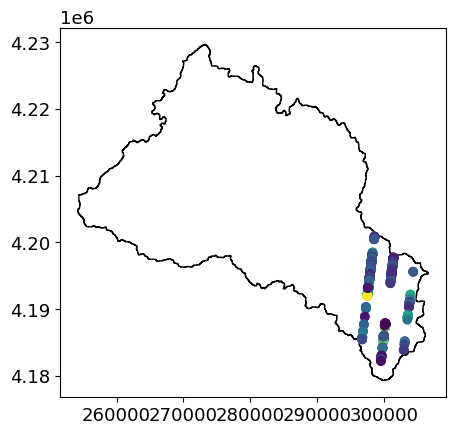

In [58]:
fig, ax = plt.subplots()

outline_gdf.plot(ax=ax,facecolor='none')
atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['acqdate']==atl06_dates[-1])].plot(column='median_slope20d',ax=ax)

In [49]:
comp_table

,acqdate,ATL06SR,ASO,pair,median,median_diff,rmse,rmse_inner,mae,mae_inner,median_track_percent,iqr,stdev,iqr_diff,iqr_track_percent,date_offset,tum_depth,dan_depth,delta_tum,delta_dan,basin_median,basin_stdev,median_basin_diff,median_basin_percent,basin_iqr,iqr_basin_diff,iqr_basin_percent,snow_presence,median_slope20d,median_slope10d,median_diff_slop10d,median_diff_slope10d,median_slope30t40d,median_diff_slope30t40d
2019-03-12,2019-03-12,True,False,0,2.485761,0.212713,1.452777,1.452777,1.051076,1.051076,NaN,2.611059,1.866957,-0.139818,NaN,12.0,2.4892,2.7178,-0.2032,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.921062,3.011761,NaN,NaN,1.688514,NaN
2019-03-24,2019-03-24,False,True,0,2.698474,0.212713,NaN,NaN,NaN,NaN,7.882707,2.471241,1.519178,-0.139818,-5.657807,12.0,2.2860,2.5654,-0.2032,-0.1524,2.838950,1.453838,-0.353189,-12.440824,1.714828,0.896232,52.263670,NaN,2.226179,3.204451,NaN,-0.192689,2.118680,-0.430166
2019-04-10,2019-04-10,True,False,1,2.395167,0.142137,0.830245,0.830245,0.598113,0.598113,NaN,1.201084,1.067347,-0.218908,NaN,7.0,2.0320,NaN,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.586704,2.356833,NaN,NaN,2.394637,NaN
2019-04-17,2019-04-17,False,True,1,2.537303,0.142137,NaN,NaN,NaN,NaN,5.601877,0.982176,0.812037,-0.218908,-22.288101,7.0,1.8796,2.2352,-0.1524,NaN,2.544456,1.508880,-0.149290,-5.867261,1.885017,-0.683933,-36.282591,NaN,2.993160,2.428219,NaN,-0.071386,3.126469,-0.731832
2019-05-03,2019-05-03,False,True,2,2.019469,-0.475851,NaN,NaN,NaN,NaN,-23.563192,1.091550,1.003791,0.619843,56.785630,11.0,1.0414,1.4732,-0.6350,-0.3302,1.719352,1.345348,-0.175735,-10.220975,1.988614,-0.277220,-13.940383,NaN,2.267671,1.850679,NaN,-0.522401,2.353126,-1.249210
2019-05-14,2019-05-14,True,False,2,1.543617,-0.475851,1.332268,1.332268,0.982664,0.982664,NaN,1.711393,1.411862,0.619843,NaN,11.0,0.4064,1.1430,-0.6350,-0.3302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.676207,1.328278,NaN,NaN,1.103915,NaN
2020-04-07,2020-04-07,True,False,3,1.278313,-0.266281,1.105683,1.105683,0.802278,0.802278,NaN,1.346704,1.327600,-0.515127,NaN,6.0,0.7112,NaN,-0.2540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.114435,1.218341,NaN,NaN,0.778972,NaN
2020-04-13,2020-04-13,False,True,3,1.012032,-0.266281,NaN,NaN,NaN,NaN,-26.311492,0.831577,0.727391,-0.515127,-61.945740,6.0,0.4572,1.5240,-0.2540,NaN,0.983526,0.793480,0.294787,29.972451,1.181436,0.165268,13.988713,NaN,1.001677,0.954436,NaN,0.263905,0.915337,-0.136365
2020-05-22,2020-05-22,False,True,4,0.000293,0.051034,NaN,NaN,NaN,NaN,17414.013292,0.276587,0.476752,0.970899,351.028985,17.0,0.0508,0.0000,0.0254,0.0000,0.010931,0.515029,0.040395,369.534408,0.337922,0.909564,269.163918,NaN,0.000000,0.000000,NaN,-0.032774,0.000000,-0.013329
2020-06-08,2020-06-08,True,False,4,0.051327,0.051034,1.297738,0.000000,0.955959,NaN,NaN,1.247486,1.223393,0.970899,NaN,17.0,0.0762,0.0000,0.0254,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.129993,-0.032774,NaN,NaN,-0.013329,NaN


In [46]:
comp_table['median_diff_slope30t40d'] = np.nan
for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
        comp_table.loc[comp_table['acqdate']==date_aso, 'median_diff_slope30t40d'] = (comp_table.loc[comp_table['acqdate']==date_atl06, 'median_slope30t40d'][0] - comp_table.loc[comp_table['acqdate']==date_aso, 'median_slope30t40d'][0])

In [47]:
np.nanmedian(comp_table['median_diff_slope30t40d'])

-0.6398801988278129

In [88]:
scipy.stats.median_abs_deviation(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['snow_presence']==0)  &
                                    (atl06sr_gdf_inner['median_slope20d']>25) & 
                                   (atl06sr_gdf_inner['median_slope20d']<30), 'diff_plus_bicubic'])

1.0301803785084758

In [90]:
np.nanmedian(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['snow_presence']==0)  &
                                    (atl06sr_gdf_inner['median_slope20d']>25) & 
                                   (atl06sr_gdf_inner['median_slope20d']<30), 'diff_plus_bicubic'])

-0.005120380441667294

In [93]:
atl06sr_gdf_inner['diff_plus_bicubic_from_aso'] = atl06sr_gdf_inner['diff_plus_bicubic'] - atl06sr_gdf_inner['ASO_snowon_bic']

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [114]:
atl06sr_gdf_inner_aso = atl06sr_gdf_inner.loc[atl06sr_gdf_inner['ASO_snowon_date'].isin(aso_date_list)]

In [115]:
atl06sr_gdf_inner_aso = atl06sr_gdf_inner_aso.dropna()

In [111]:
atl06sr_gdf_inner.loc[atl06sr_gdf_inner['ASO_snowon_date'].isin(aso_date_list), 'diff_plus_bicubic_from_aso'].values

array([ 1.20348664, -0.13803241,  0.78955549, ...,         nan,
               nan,         nan])

In [120]:
scipy.stats.median_abs_deviation(
    atl06sr_gdf_inner_aso.loc[atl06sr_gdf_inner_aso['ASO_snowon_date'].isin(aso_date_list) & 
                              atl06sr_gdf_inner_aso['median_slope20d']<10, 
                              'diff_plus_bicubic_from_aso'])

0.6219634184687555

In [181]:
atl06sr_gdf_inner_aso_2019 = atl06sr_gdf_inner_aso.loc[atl06sr_gdf_inner_aso.index.date == datetime.date(2019,3,12)]

In [191]:
atl06_subset = gpd.read_file('../../../data/site_outlines/tuol_atl06_subset.geojson')

In [193]:
atl06sr_gdf_inner_aso_2019_clipped = gpd.clip(atl06sr_gdf_inner_aso_2019, atl06_subset.to_crs('epsg:32611'))

<AxesSubplot: >

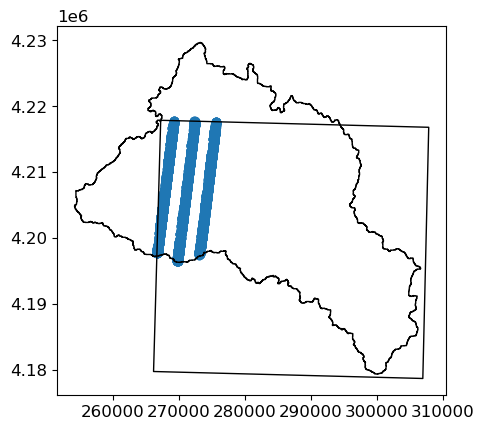

In [195]:
fig, ax=plt.subplots()
atl06sr_gdf_inner_aso_2019_clipped.plot(ax=ax)
outline_gdf.plot(ax=ax, facecolor='none')
atl06_subset.to_crs('epsg:32611').plot(ax=ax, facecolor='none')

In [198]:
np.nanmedian(atl06sr_gdf_inner_aso_2019_clipped.loc[atl06sr_gdf_inner_aso_2019_clipped['median_slope20d']<10, 
                              'diff_plus_bicubic_from_aso'])

-0.05282573421145864

In [199]:
scipy.stats.median_abs_deviation(
    atl06sr_gdf_inner_aso_2019_clipped.loc[atl06sr_gdf_inner_aso_2019_clipped['median_slope20d']<10, 
                              'diff_plus_bicubic_from_aso'], scale='normal')

0.6096185175364242

In [200]:
scipy.stats.median_abs_deviation(
    atl06sr_gdf_inner_aso_2019_clipped.loc[
                              (atl06sr_gdf_inner_aso_2019_clipped['median_slope20d']>30) &
                              (atl06sr_gdf_inner_aso_2019_clipped['median_slope20d']<40), 
                              'diff_plus_bicubic_from_aso'], scale='normal')

1.6699251335131917

In [174]:
scipy.stats.median_abs_deviation(atl06sr_gdf_inner['diff_plus_bicubic_from_aso'].dropna(), scale='normal')

0.9229293481724883

In [201]:
np.nanmedian(atl06sr_gdf_inner_aso_2019_clipped.loc[
                              (atl06sr_gdf_inner_aso_2019_clipped['median_slope20d']>30) &
                              (atl06sr_gdf_inner_aso_2019_clipped['median_slope20d']<40), 
                              'diff_plus_bicubic_from_aso'])

-0.5615545474315068

In [168]:
atl06sr_gdf_inner_aso_2019.loc[
                              (atl06sr_gdf_inner_aso_2019['median_slope20d']>30) &
                              (atl06sr_gdf_inner_aso_2019['median_slope20d']<40)]['median_slope20d'].describe()

count    934.000000
mean      34.517528
std        2.750457
min       30.001381
25%       32.137016
50%       34.233232
75%       36.809883
max       39.946885
Name: median_slope20d, dtype: float64

In [170]:
atl06sr_gdf_inner['diff_plus_bicubic_from_aso'].describe()

count    33075.000000
mean        -0.276516
std          1.197802
min         -7.262291
25%         -0.850955
50%         -0.184578
75%          0.403789
max          4.904950
Name: diff_plus_bicubic_from_aso, dtype: float64

In [145]:
atl06sr_gdf_inner_aso.loc[(atl06sr_gdf_inner_aso['ASO_snowon_date'].isin(aso_date_list)) & 
                              atl06sr_gdf_inner_aso['median_slope20d']<10, 
                              'diff_plus_bicubic_from_aso']

time
2019-03-12 04:32:59.963171016    0.803131
2019-03-12 04:32:59.968840304   -0.004059
2019-03-12 04:32:59.971681888    0.378944
2019-03-12 04:32:59.977366968    0.807012
2019-03-12 04:32:59.980082072   -0.140240
                                   ...   
2022-04-03 23:07:02.945372016   -0.201062
2022-04-03 23:07:02.976343392    0.683781
2022-04-03 23:07:02.979131904    0.143407
2022-04-03 23:07:02.981923968    0.042946
2022-04-03 23:07:02.984719984    0.572011
Name: diff_plus_bicubic_from_aso, Length: 32941, dtype: float64

In [142]:
(atl06sr_gdf_inner_aso['ASO_snowon_date'].isin(aso_date_list))

time
2019-03-12 04:32:59.963171016    True
2019-03-12 04:32:59.968840304    True
2019-03-12 04:32:59.971681888    True
2019-03-12 04:32:59.977366968    True
2019-03-12 04:32:59.980082072    True
                                 ... 
2022-04-03 23:07:02.945372016    True
2022-04-03 23:07:02.976343392    True
2022-04-03 23:07:02.979131904    True
2022-04-03 23:07:02.981923968    True
2022-04-03 23:07:02.984719984    True
Name: ASO_snowon_date, Length: 32941, dtype: bool

In [141]:
scipy.stats.median_abs_deviation(
    atl06sr_gdf_inner_aso.loc[(atl06sr_gdf_inner_aso['ASO_snowon_date']==aso_date_list[0]) & 
                              atl06sr_gdf_inner_aso['median_slope20d']<10, 
                              'diff_plus_bicubic_from_aso'], scale='normal')

0.9221243440511049

In [146]:
atl06sr_gdf_inner_aso.loc[(atl06sr_gdf_inner_aso.acqdate==atl06_dates[0]) & 
                              atl06sr_gdf_inner_aso['median_slope20d']<10, 
                              'diff_plus_bicubic_from_aso']

time
2019-03-12 04:32:59.963171016    0.803131
2019-03-12 04:32:59.968840304   -0.004059
2019-03-12 04:32:59.971681888    0.378944
2019-03-12 04:32:59.977366968    0.807012
2019-03-12 04:32:59.980082072   -0.140240
                                   ...   
2022-04-03 23:07:02.945372016   -0.201062
2022-04-03 23:07:02.976343392    0.683781
2022-04-03 23:07:02.979131904    0.143407
2022-04-03 23:07:02.981923968    0.042946
2022-04-03 23:07:02.984719984    0.572011
Name: diff_plus_bicubic_from_aso, Length: 32941, dtype: float64

In [157]:
atl06sr_gdf_inner_aso[atl06sr_gdf_inner_aso.index.date == datetime.date(2019,3,12)]

,distance,h_sigma,rgt,delta_time,pflags,dh_fit_dy,segment_id,w_surface_window_final,dh_fit_dx,h_mean,spot,gt,cycle,rms_misfit,n_fit_photons,geometry,doy,decyear,dowy,snow_presence,lidar_z,difference,bicubic_lidar_z,sampling_dif,difference_bicubic,site,acqdate,n,diff_plus,diff_plus_bicubic,zscore,ASO_snowon,ASO_snowon_date,ASO_snowon_bic,median_slope20d,diff_plus_bicubic_from_aso
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-12 04:32:59.963171016,1.582309e+07,0.027070,1126,3.760038e+07,0,0.0,789989,3.809001,-0.147435,2870.128368,3,30,2,0.445395,287,POINT (273814.171 4228832.959),71,2019.1923,163,1,2865.574951,4.553417,2865.706067,-0.131116,4.422301,tuolumne,2019-03-12,6001,4.667954,4.520895,2.356017,3.812849,2019-03-24,3.717764,12.391517,0.803131
2019-03-12 04:32:59.968840304,1.582313e+07,0.022152,1126,3.760038e+07,0,0.0,789991,3.000000,-0.050178,2866.964660,3,30,2,0.350855,253,POINT (273809.264 4228793.159),71,2019.1923,163,1,2862.968018,3.996643,2862.954910,0.013108,4.009751,tuolumne,2019-03-12,6001,4.111180,4.108345,2.115195,4.190535,2019-03-24,4.112405,7.639319,-0.004059
2019-03-12 04:32:59.971681888,1.582315e+07,0.033493,1126,3.760038e+07,0,0.0,789992,3.269441,-0.107747,2865.255650,3,30,2,0.532488,253,POINT (273806.815 4228773.259),71,2019.1923,163,1,2860.917969,4.337681,2860.528729,0.389240,4.726921,tuolumne,2019-03-12,6001,4.452218,4.825516,2.533837,4.579206,2019-03-24,4.446571,7.967227,0.378944
2019-03-12 04:32:59.977366968,1.582319e+07,0.062103,1126,3.760038e+07,0,0.0,789994,3.077486,-0.118279,2861.542799,3,30,2,0.245186,76,POINT (273801.925 4228733.457),71,2019.1923,163,1,2857.429932,4.112868,2857.424195,0.005737,4.118605,tuolumne,2019-03-12,6001,4.227405,4.217199,2.178737,3.339461,2019-03-24,3.410187,9.263224,0.807012
2019-03-12 04:32:59.980082072,1.582321e+07,0.098722,1126,3.760038e+07,4,0.0,789995,3.000000,-0.113724,2858.891182,3,30,2,0.506170,47,POINT (273799.592 4228714.416),71,2019.1923,163,1,2855.881104,3.010078,2855.904676,-0.023572,2.986506,tuolumne,2019-03-12,6001,3.124615,3.085100,1.517884,3.210310,2019-03-24,3.225340,10.524113,-0.140240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-12 04:33:04.883596168,1.585566e+07,0.096067,1126,3.760038e+07,0,0.0,791614,10.360698,0.405593,2575.757627,4,40,2,0.585652,41,POINT (269700.224 4196511.093),71,2019.1923,163,1,2572.378906,3.378720,2572.879418,-0.500512,2.878208,tuolumne,2019-03-12,6001,3.493257,2.976803,1.454666,3.741316,2019-03-24,3.744265,23.661592,-0.767462
2019-03-12 04:33:04.886423720,1.585568e+07,0.088058,1126,3.760038e+07,0,0.0,791615,13.270580,0.519862,2584.764345,4,40,2,0.537707,38,POINT (269697.688 4196491.202),71,2019.1923,163,1,2581.075928,3.688417,2581.394431,-0.318504,3.369914,tuolumne,2019-03-12,6001,3.802954,3.468508,1.741695,3.776961,2019-03-24,3.609919,24.680739,-0.141411
2019-03-12 04:33:04.889246720,1.585570e+07,0.079459,1126,3.760038e+07,0,0.0,791616,14.794405,0.579677,2595.691487,4,40,2,0.463141,38,POINT (269695.177 4196471.309),71,2019.1923,163,1,2592.989990,2.701497,2592.575108,0.414882,3.116379,tuolumne,2019-03-12,6001,2.816034,3.214974,1.593696,4.149031,2019-03-24,4.010414,27.528619,-0.795440


In [143]:
aso_date_list[0]

datetime.date(2019, 3, 24)

In [139]:
np.nanmedian(atl06sr_gdf_inner_aso.loc[(atl06sr_gdf_inner_aso['ASO_snowon_date'].isin(aso_date_list)) & 
                              atl06sr_gdf_inner_aso['median_slope20d']<10, 
                              'diff_plus_bicubic_from_aso'])

-0.18362441886205416

In [119]:
scipy.stats.median_abs_deviation(
    atl06sr_gdf_inner_aso.loc[atl06sr_gdf_inner_aso['ASO_snowon_date'].isin(aso_date_list) & 
                              (atl06sr_gdf_inner_aso['median_slope20d']>30) &
                              (atl06sr_gdf_inner_aso['median_slope20d']<40), 
                              'diff_plus_bicubic_from_aso'])

1.2431053819866205

In [ ]:
scipy.stats.median_abs_deviation(
    atl06sr_gdf_inner_aso.loc[atl06sr_gdf_inner_aso['ASO_snowon_date'].isin(aso_date_list) & 
                              (atl06sr_gdf_inner_aso['median_slope20d']>30) &
                              (atl06sr_gdf_inner_aso['median_slope20d']<40), 
                              'diff_plus_bicubic_from_aso'])

In [135]:
np.nanmedian(atl06sr_gdf_inner_aso.loc[atl06sr_gdf_inner_aso['ASO_snowon_date'].isin(aso_date_list) & 
                              (atl06sr_gdf_inner_aso['median_slope20d']>30) &
                              (atl06sr_gdf_inner_aso['median_slope20d']<40), 
                              'diff_plus_bicubic_from_aso'])

-0.6122787541421644

In [126]:
scipy.stats.median_abs_deviation(
    atl06sr_gdf_inner_aso.loc[atl06sr_gdf_inner_aso['ASO_snowon_date'].isin(aso_date_list) & 
                              (atl06sr_gdf_inner_aso['median_slope20d']>30) &
                              (atl06sr_gdf_inner_aso['median_slope20d']<40), 
                              'diff_plus_bicubic_from_aso']) *1.4826

1.8430280393333633

In [123]:
len(atl06sr_gdf_inner_aso.loc[atl06sr_gdf_inner_aso['ASO_snowon_date'].isin(aso_date_list) & 
                              (atl06sr_gdf_inner_aso['median_slope20d']>30) &
                              (atl06sr_gdf_inner_aso['median_slope20d']<40), 
                              'diff_plus_bicubic_from_aso'])

3656

In [ ]:
scipy.stats.median_abs_deviation(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['snow_presence']==0)  &
                                    (atl06sr_gdf_inner['median_slope20d']>25) & 
                                   (atl06sr_gdf_inner['median_slope20d']<30), 'diff_plus_bicubic'])

In [92]:
np.nanmedian(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['snow_presence']==0) &
                                    (atl06sr_gdf_inner['median_slope20d']<5), 'diff_plus_bicubic'])

-0.05648858068980189

In [89]:
scipy.stats.median_abs_deviation(atl06sr_gdf_inner.loc[(atl06sr_gdf_inner['snow_presence']==0) &
                                    (atl06sr_gdf_inner['median_slope20d']<5), 'diff_plus_bicubic'])

0.2603981216079774

In [59]:
np.nanmean(comp_table['median_diff_slope30t40d'])

-0.6348284895669509

In [28]:
pairs_tumradius = make_pairs_table(atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[2, 'geometry'])])

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [29]:
pairs_danradius = make_pairs_table(atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[3, 'geometry'])])

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [145]:
#comp_table.to_csv('../../figures/comp_table_pairs.csv')

In [110]:
basin_df = build_basin_df(raster_list=aso_fn_winters, region=outline_gdf)
basin_df

,min,max,mean,count,median,percentile_25,percentile_75,iqr,acqdate
2019-03-24,-1.039112,22.367649,2.744573,2915368,2.838950,1.887053,3.601881,1.714828,2019-03-24
2019-04-17,-0.879300,22.962400,2.443612,2915748,2.544456,1.465045,3.350062,1.885017,2019-04-17
2019-05-03,-1.206003,42.400269,1.708364,2915383,1.719352,0.533913,2.522527,1.988614,2019-05-03
2020-04-13,-0.292035,21.189863,0.983854,2646253,0.983526,0.289719,1.471155,1.181436,2020-04-13
2020-05-22,-0.218361,20.824833,0.265674,2792407,0.010931,0.000000,0.337922,0.337922,2020-05-22
2021-02-25,-0.366888,7.820531,0.966758,2906850,1.049031,0.621652,1.327524,0.705872,2021-02-25
2022-02-04,-0.232013,11.518790,1.000802,1235354,1.036890,0.647384,1.318633,0.671249,2022-02-04
2022-04-05,-0.200172,11.080725,0.609790,1157340,0.508277,0.115128,0.909294,0.794165,2022-04-05


In [105]:
comp_table

,acqdate,ATL06SR,ASO,pair,median,median_diff,median_track_percent,iqr,iqr_diff,iqr_track_percent,date_offset,tum_depth,dan_depth,delta_tum,delta_dan,basin_median,median_basin_diff,median_basin_percent,basin_iqr,iqr_basin_diff,iqr_basin_percent
2019-03-12,2019-03-12,True,False,0,2.825406,0.155656,NaN,2.909036,-0.312845,NaN,12,2.4892,2.7178,-0.2032,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-24,2019-03-24,False,True,0,2.981062,0.155656,5.221507,2.596191,-0.312845,-12.05014,12,2.286,2.5654,-0.2032,-0.1524,2.838950,-0.013544,-0.477074,1.714828,1.194208,69.640142
2019-04-10,2019-04-10,True,False,1,2.452357,0.106477,NaN,1.248204,-0.2244,NaN,7,2.032,NaN,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-17,2019-04-17,False,True,1,2.558834,0.106477,4.161163,1.023804,-0.2244,-21.918265,7,1.8796,2.2352,-0.1524,NaN,2.544456,-0.092099,-3.619612,1.885017,-0.636813,-33.782884
2019-05-03,2019-05-03,False,True,2,2.037935,-0.441766,-21.677132,1.147949,0.630284,54.905226,11,1.0414,1.4732,-0.635,-0.3302,1.719352,-0.123183,-7.164508,1.988614,-0.210380,-10.579248
2019-05-14,2019-05-14,True,False,2,1.596169,-0.441766,NaN,1.778233,0.630284,NaN,11,0.4064,1.143,-0.635,-0.3302,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-07,2020-04-07,True,False,3,1.296197,-0.276697,NaN,1.422136,-0.578227,NaN,6,0.7112,NaN,-0.254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-13,2020-04-13,False,True,3,1.0195,-0.276697,-27.140498,0.843909,-0.578227,-68.517762,6,0.4572,1.524,-0.254,NaN,0.983526,0.312670,31.790754,1.181436,0.240700,20.373464
2020-05-22,2020-05-22,False,True,4,0.0,0.041656,inf,0.298129,1.01513,340.499902,17,0.0508,0.0,0.0254,0.0,0.010931,0.030725,281.066764,0.337922,0.975338,288.628022
2020-06-08,2020-06-08,True,False,4,0.041656,0.041656,NaN,1.313259,1.01513,NaN,17,0.0762,0.0,0.0254,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
median_dif = comp_table['median_diff']

In [139]:
np.sort(median_dif.abs())

array([4.899748319076025e-06, 4.899748319076025e-06, 0.04165602668763313,
       0.04165602668763313, 0.10647727818263775, 0.10647727818263775,
       0.1556563759902474, 0.1556563759902474, 0.22236200336578804,
       0.22236200336578804, 0.23193502764502227, 0.23193502764502227,
       0.27669725018768077, 0.27669725018768077, 0.44176575335950474,
       0.44176575335950474], dtype=object)

In [138]:
len(median_dif)

16

In [20]:
basin_dif = comp_table['median_basin_diff']

In [143]:
np.sort(basin_dif.abs())

array([0.01354388, 0.0307246 , 0.08152943, 0.09209945, 0.1231831 ,
       0.1515677 , 0.20371099, 0.31267044,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan])

In [98]:
np.nanmedian(comp_table['median_basin_diff'].abs())

0.10764127256504707

In [99]:
np.nanmedian(comp_table['median_basin_percent'].abs())

15.328938327485382

In [106]:
np.nanmedian(comp_table['iqr_basin_diff'].abs())

0.5554237444039245

In [107]:
np.nanmedian(comp_table['iqr_basin_percent'].abs())

50.469380230148346

In [74]:
np.nanmedian(comp_table[comp_table['acqdate'].isin(atl06_dates)]['median_diff'])

0.037224968139239256

In [122]:
np.nanmedian(comp_table[comp_table['acqdate'].isin(atl06_dates)]['date_offset'].abs())

9.0

In [ ]:
metrics = ['date_offset', 'median_diff', 'median_track_percent', 'iqr_diff', 'iqr_track_percent', \
          'delta_tum', 'delta_dan', 'basin_median', 'median_basin_diff']

In [206]:
comp_table.columns[12:13]

Index(['stdev'], dtype='object')

In [72]:
for column in comp_table.columns[4:5]:
    print(column, "atl06 median:", np.nanmedian(comp_table[comp_table['acqdate'].isin(atl06_dates)][column]))
for column in comp_table.columns[12:13]:
    print(column, "atl06 median:", np.nanmedian(comp_table[comp_table['acqdate'].isin(atl06_dates)][column]))
for column in comp_table.columns[12:13]:
    print(column, "aso median:", np.nanmedian(comp_table[comp_table['acqdate'].isin(aso_date_list)][column]))
for column in comp_table.columns[4:5]:
    print(column, "aso median:", np.nanmedian(comp_table[comp_table['acqdate'].isin(aso_date_list)][column]))
for column in comp_table.columns[5:6]:
    print(column, "median:", np.nanmedian(comp_table[column]))
for column in comp_table.columns[6:]:
    print(column, "median:", np.nanmedian(comp_table[comp_table['acqdate'].isin(aso_date_list)][column]))

median atl06 median: 1.0751915033082469
tum_depth atl06 median: 0.9017000000000001
tum_depth aso median: 1.0795000000000001
median aso median: 1.0946766261143002
median_diff median: 0.037224968139239256
rmse median: nan
mae median: nan
iqr median: 0.6674024569083803
stdev median: 0.6513947907493293
iqr_diff median: -0.21483200491849863
date_offset median: 9.0
tum_depth median: 1.0795000000000001
dan_depth median: 1.4986
delta_tum median: -0.11429999999999993
delta_dan median: -0.025400000000000034
basin_median median: 1.042960524559021
basin_stdev median: 0.6978562147821592
median_basin_diff median: -0.14041908956323823
median_basin_percent median: -6.076605997654335
basin_iqr median: 0.9878007937222719
iqr_basin_diff median: 0.3015862807949361
snow_presence median: nan
median_slope5d median: 1.1210691056700055
median_diff_slope5d median: -0.12497871344179884
median_slope25t30d median: 1.1319092207315733
median_diff_slope25t30d median: -0.4555957151857226


In [211]:
np.nanmedian(comp_table['rmse'].dropna())

1.1982799018448218

In [185]:
comp_table.loc[comp_table['acqdate'].isin(aso_date_list), 'basin_median']

2019-03-24    2.838950
2019-04-17    2.544456
2019-05-03    1.719352
2020-04-13    0.983526
2020-05-22    0.010931
2021-02-25    1.049031
2022-02-04    1.036890
2022-04-05    0.508277
Name: basin_median, dtype: float64

Text(0.5, 0, 'Basin Median (ASO)')

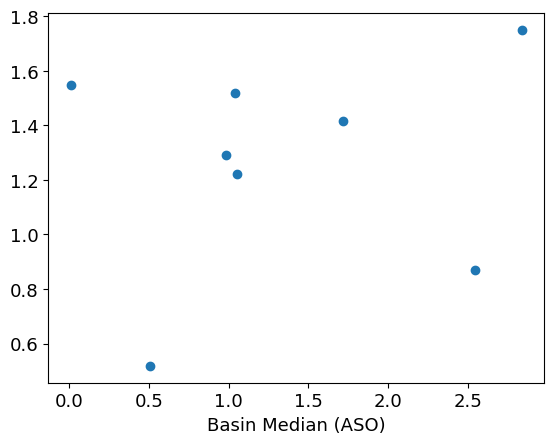

In [186]:
x = np.linspace(0,3,100)
y = x

fig, ax = plt.subplots()
ax.scatter(comp_table.loc[comp_table['acqdate'].isin(aso_date_list), 'basin_median'], comp_table['rmse'].dropna())
#ax.plot(x, y, 'darkgrey', label='1:1 line')
ax.set_xlabel('Basin Median (ASO)')

Text(0.5, 0, 'Basin Median (ASO)')

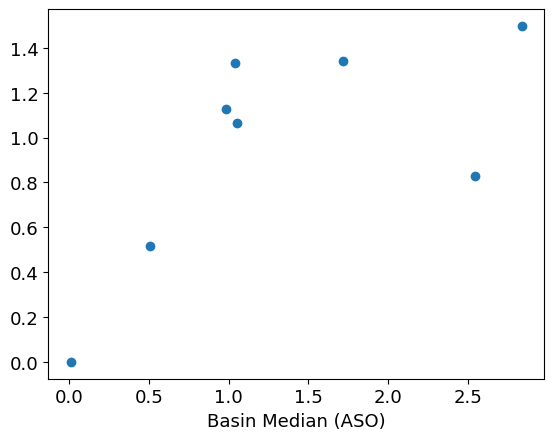

In [197]:
x = np.linspace(0,3,100)
y = x

fig, ax = plt.subplots()
ax.scatter(comp_table.loc[comp_table['acqdate'].isin(aso_date_list), 'basin_median'], comp_table['rmse_inner'].dropna())
#ax.plot(x, y, 'darkgrey', label='1:1 line')
ax.set_xlabel('Basin Median (ASO)')

Text(0, 0.5, 'MAE')

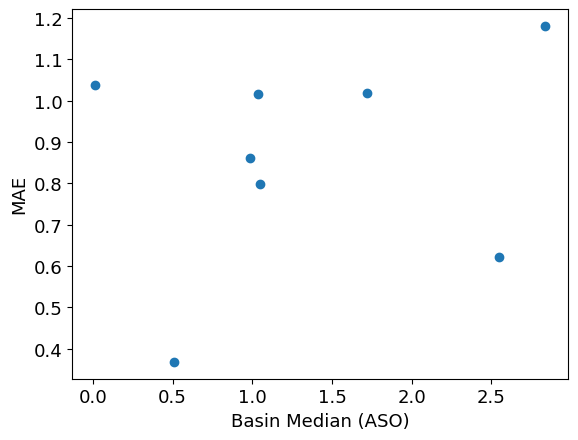

In [35]:
fig, ax = plt.subplots()
ax.scatter(comp_table.loc[comp_table['acqdate'].isin(aso_date_list), 'basin_median'], comp_table['mae'].dropna())
#ax.plot(x, y, 'darkgrey', label='1:1 line')
ax.set_xlabel('Basin Median (ASO)')
ax.set_ylabel('MAE')

In [64]:
aso_date_list_mae = aso_date_list[0:4]
aso_date_list_mae.append(aso_date_list[5])
aso_date_list_mae.append(aso_date_list[6])
aso_date_list_mae.append(aso_date_list[7])

In [65]:
aso_date_list_mae

[datetime.date(2019, 3, 24),
 datetime.date(2019, 4, 17),
 datetime.date(2019, 5, 3),
 datetime.date(2020, 4, 13),
 datetime.date(2021, 2, 25),
 datetime.date(2022, 2, 4),
 datetime.date(2022, 4, 5)]

In [55]:
aso_date_list

[datetime.date(2019, 3, 24),
 datetime.date(2019, 4, 17),
 datetime.date(2019, 5, 3),
 datetime.date(2020, 4, 13),
 datetime.date(2020, 5, 22),
 datetime.date(2021, 2, 25),
 datetime.date(2022, 2, 4),
 datetime.date(2022, 4, 5)]

Text(0, 0.5, 'Inner MAE')

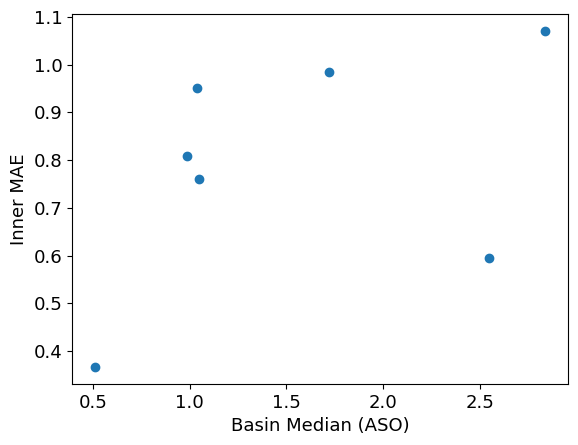

In [66]:
fig, ax = plt.subplots()
ax.scatter(comp_table.loc[comp_table['acqdate'].isin(aso_date_list_mae), 'basin_median'], comp_table['mae_inner'].dropna())
#ax.plot(x, y, 'darkgrey', label='1:1 line')
ax.set_xlabel('Basin Median (ASO)')
ax.set_ylabel('Inner MAE')

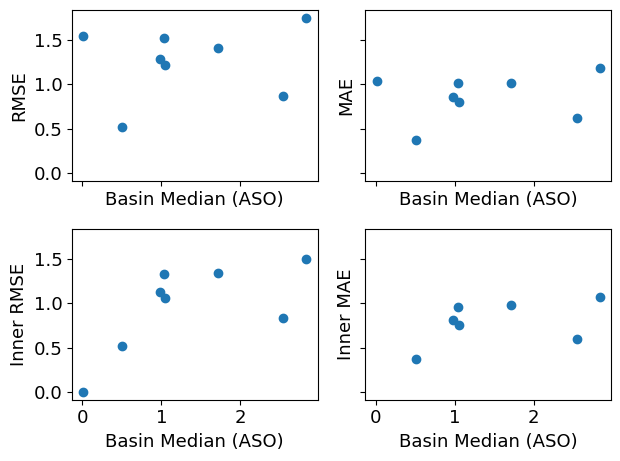

In [126]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)

ax[0][0].scatter(comp_table.loc[comp_table['acqdate'].isin(aso_date_list), 'basin_median'], comp_table['rmse'].dropna())
ax[0][0].set_xlabel('Basin Median (ASO)')
ax[0][0].set_ylabel('RMSE')

ax[1][0].scatter(comp_table.loc[comp_table['acqdate'].isin(aso_date_list), 'basin_median'], comp_table['rmse_inner'].dropna())
ax[1][0].set_xlabel('Basin Median (ASO)')
ax[1][0].set_ylabel('Inner RMSE')

ax[0][1].scatter(comp_table.loc[comp_table['acqdate'].isin(aso_date_list), 'basin_median'], comp_table['mae'].dropna())
ax[0][1].set_xlabel('Basin Median (ASO)')
ax[0][1].set_ylabel('MAE')

ax[1][1].scatter(comp_table.loc[comp_table['acqdate'].isin(aso_date_list_mae), 'basin_median'], comp_table['mae_inner'].dropna())
ax[1][1].set_xlabel('Basin Median (ASO)')
ax[1][1].set_ylabel('Inner MAE')

plt.tight_layout()

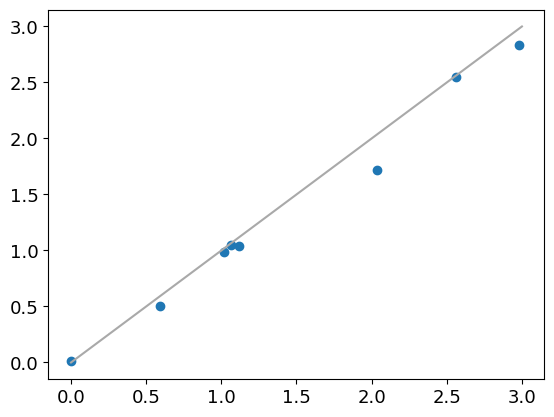

In [61]:
x = np.linspace(0,3,100)
y = x

fig, ax = plt.subplots()
ax.scatter(comp_table['basin_median'], comp_table['median'])
ax.plot(x, y, 'darkgrey', label='1:1 line')
ax.set_xlabel('Basin Median (ASO)')

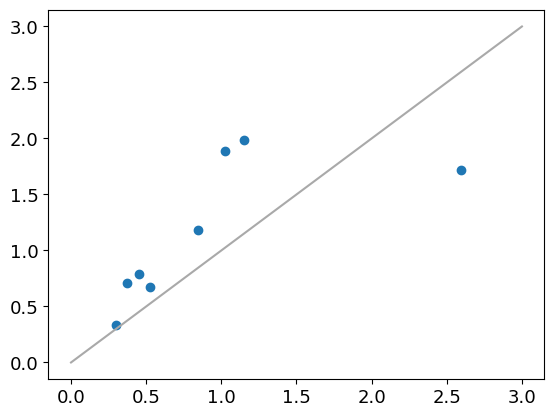

In [62]:
x = np.linspace(0,3,100)
y = x

fig, ax = plt.subplots()
ax.scatter(comp_table['iqr'], comp_table['basin_iqr'])
ax.plot(x, y, 'darkgrey', label='1:1 line')

Text(0, 0.5, 'delta snow depth during \nthe date offset at tum')

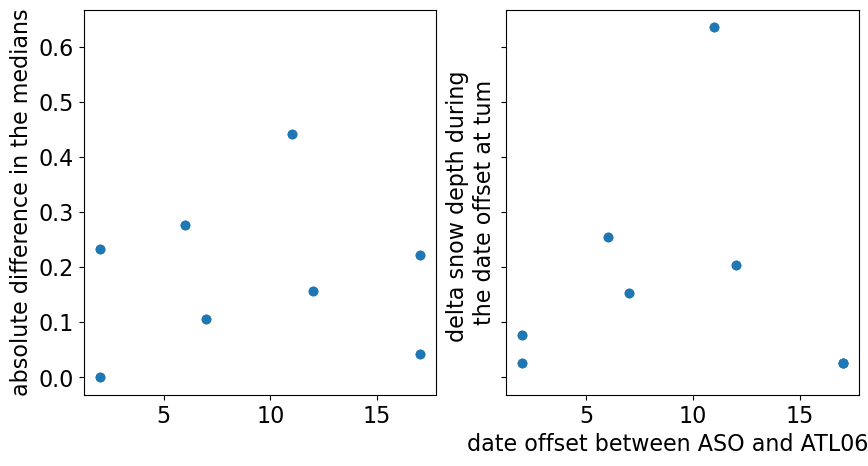

In [98]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
ax[0].scatter(comp_table['date_offset'], comp_table['median_diff'].abs())
#ax[0].set_xlabel('date offset between ASO and ATL06SR')
ax[0].set_ylabel('absolute difference in the medians')

ax[1].scatter(comp_table['date_offset'], comp_table['delta_tum'].abs())
ax[1].set_xlabel('date offset between ASO and ATL06SR')
ax[1].set_ylabel('delta snow depth during \nthe date offset at tum')

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(10,10), gridspec_kw={'height_ratios': [3, 3, 1], 'width_ratios': [1,1]})

In [62]:
# Old Plotting Function

# def plot_pair_locations(gdf, df, roi, roi_reverse, wx_stations):
    
#     basemap = cx.providers.Stamen.TerrainBackground
    
#     fig, ax = plt.subplots(2,2, figsize=(10,10), gridspec_kw={'height_ratios':[1,2], 'width_ratios':[1,1]})
    
#     # Plot changes in snow depth
#     x = np.linspace(-7,0.3,100)
#     y = x

#     c=ax[0,0].scatter(df['delta_tum'], df['median_diff'], c=df['pair'], cmap='Blues_r')
#     ax[0,0].plot(x, y, 'darkgrey', label='1:1 line')
#     ax[0,0].axvline(x=0, ymin=(-0.7), ymax=1, color='grey')
#     ax[0,0].axhline(y=0, xmin=(-0.7), xmax=1, color='grey')
#     plt.colorbar(c, label='Pair', ax=ax[0,0])
#     #plt.ylim(-100, 100)
#     #plt.hlines(y=0, xmin=0, xmax=17.5, color='k', linestyle='--')
#     ax[0,0].set_ylim(-0.7, 0.3)
#     ax[0,0].set_xlim(-0.7, 0.3)
#     ax[0,0].set_xlabel('Change in TUM Depth (m)')
#     ax[0,0].set_ylabel('median difference (ATL06SR-ASO)')
#     ax[0,0].set_facecolor('lightgrey')

In [141]:
# Old Plotting Function

# def plot_pair_locations(gdf, df, roi, roi_reverse, wx_stations):
    
#     basemap = cx.providers.Stamen.TerrainBackground
#     # code from https://towardsdatascience.com/customizing-multiple-subplots-in-matplotlib-a3e1c2e099bc
#     fig = plt.figure(figsize=(10, 8))

#     plt.subplots_adjust(wspace= 0.5, hspace= 0.25)

#     sub1 = fig.add_subplot(2,2,1) # two rows, two columns, fist cell
#     sub1.scatter(df['delta_tum'], df['median_diff'], c=df['pair'].map(colordict))
#     sub1.plot(x, y, 'darkgrey', label='1:1 line')
#     sub1.axvline(x=0, ymin=(-0.7), ymax=1, color='lightgrey')
#     sub1.axhline(y=0, xmin=(-0.7), xmax=1, color='lightgrey')
#     #plt.colorbar(c, label='Pair', ax=sub1)
#     #plt.ylim(-100, 100)
#     #plt.hlines(y=0, xmin=0, xmax=17.5, color='k', linestyle='--')
#     sub1.set_ylim(-0.7, 0.3)
#     sub1.set_xlim(-0.7, 0.3)
#     sub1.set_xlabel('Tuolumne Meadows \nDepth Change (m)')
#     sub1.set_ylabel('Median Difference \nBetween Pairs (m)')
#     #sub1.set_facecolor('lightgrey')
    
#     # Create second axes, the top-left plot with orange plot
#     sub2 = fig.add_subplot(2,2,2) # two rows, two columns, second cell
#     sub2.scatter(df['delta_dan'], df['median_diff'], c=df['pair'].map(colordict))
#     sub2.plot(x, y, 'darkgrey', label='1:1 line')
#     sub2.axvline(x=0, ymin=(-0.7), ymax=1, color='lightgrey')
#     sub2.axhline(y=0, xmin=(-0.7), xmax=1, color='lightgrey')
#     #plt.colorbar(c, label='Number of Days \nBetween Measurements')
#     #plt.ylim(-100, 100)
#     #plt.hlines(y=0, xmin=0, xmax=17.5, color='k', linestyle='--')
#     sub2.set_ylim(-0.7, 0.3)
#     sub2.set_xlim(-0.7, 0.3)
#     sub2.set_xlabel('Dana Meadow \nDepth Change (m)')
#     sub2.set_ylabel('Median Difference \nBetween Pairs (m)')
#     #sub2.set_facecolor('lightgrey')
    
#     # Create third axes, a combination of third and fourth cell
#     sub3 = fig.add_subplot(2,2,(3,4)) # two rows, two colums, combined third and fourth cell
#     gdf[gdf['ASO_snowon_date'].isin(aso_date_list)].plot(column='acqdate', cmap=pair_cmap, ax=sub3, markersize=3, \
#                 legend=True, legend_kwds={'bbox_to_anchor':(0.93, 1.02)})
#     roi.plot(ax=sub3, facecolor='none', edgecolor='k')
#     cx.add_basemap(ax=sub3, attribution=False, crs='epsg:32611', source=basemap, zoom=11)
#     roi_reverse.plot(ax=sub3, facecolor='white')
#     wx_stations[0:2].plot(ax=sub3, color='k', marker='*', markersize=100, label='CDEC Sites', legend=True)
#     wx_stations[2:].plot(ax=sub3, facecolor='none',edgecolor='k')
#     # legend = sub3.legend(snow, 'CDEC Sites', loc='upper left')
#     # sub3.add_artist(legend)
#     sub3.set_xlim(250000, 310000)
#     sub3.set_ylim(4178000, 4232000)
#     sub3.set_axis_off()
#     plt.savefig('../../figures/polished/pairs_cdec_locations.jpeg', dpi = 500, bbox_inches = 'tight')

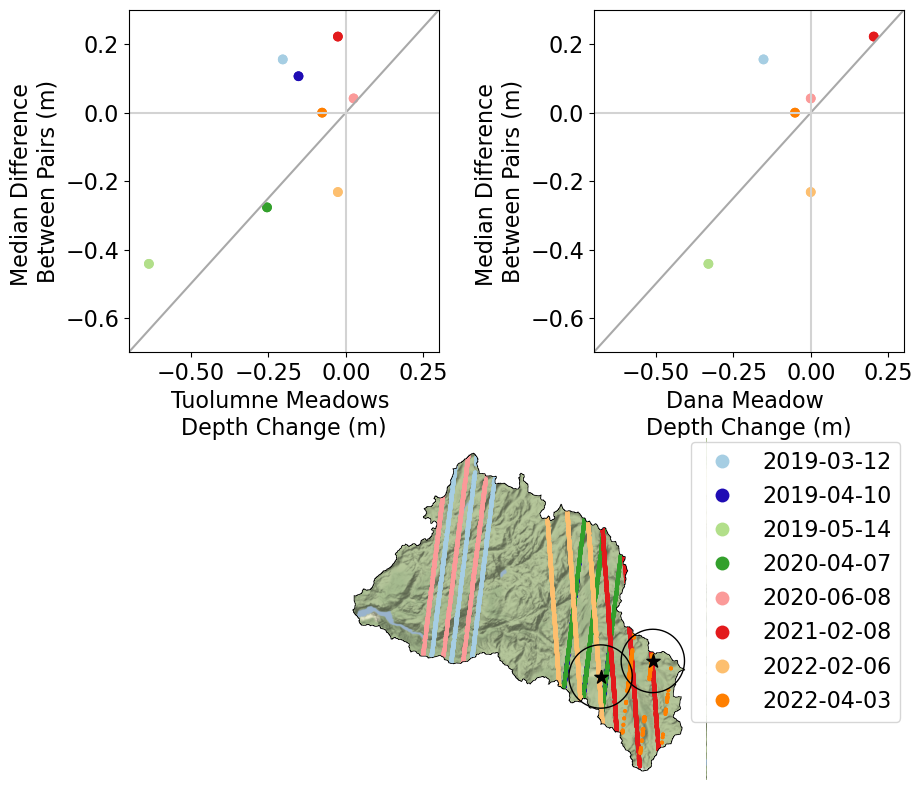

In [142]:
plot_pair_locations(atl06sr_gdf, comp_table, outline_gdf, tuol_reverse, cdec_geom)

In [21]:
comp_table.head()

,acqdate,ATL06SR,ASO,pair,median,median_diff,median_track_percent,iqr,iqr_diff,iqr_track_percent,date_offset,tum_depth,dan_depth,delta_tum,delta_dan,basin_median,median_basin_percent,basin_iqr,iqr_basin_percent
2019-03-12,2019-03-12,True,False,0,2.825406,0.155656,NaN,2.909036,-0.312845,NaN,12,2.4892,2.7178,-0.2032,-0.1524,NaN,NaN,NaN,NaN
2019-03-24,2019-03-24,False,True,0,2.981062,0.155656,5.221507,2.596191,-0.312845,-12.05014,12,2.286,2.5654,-0.2032,-0.1524,2.838950,5.482886,1.714828,-18.243507
2019-04-10,2019-04-10,True,False,1,2.452357,0.106477,NaN,1.248204,-0.2244,NaN,7,2.032,NaN,-0.1524,NaN,NaN,NaN,NaN,NaN
2019-04-17,2019-04-17,False,True,1,2.558834,0.106477,4.161163,1.023804,-0.2244,-21.918265,7,1.8796,2.2352,-0.1524,NaN,2.544456,4.184677,1.885017,-11.904404
2019-05-03,2019-05-03,False,True,2,2.037935,-0.441766,-21.677132,1.147949,0.630284,54.905226,11,1.0414,1.4732,-0.635,-0.3302,1.719352,-25.693737,1.988614,31.694648


In [70]:
aso_date_list

[datetime.date(2019, 3, 24),
 datetime.date(2019, 4, 17),
 datetime.date(2019, 5, 3),
 datetime.date(2020, 4, 13),
 datetime.date(2020, 5, 22),
 datetime.date(2021, 2, 25),
 datetime.date(2022, 2, 4),
 datetime.date(2022, 4, 5)]

In [47]:
import matplotlib
pair_colors = [(166/255,206/255,227/255), (31/255,12/255,180/255), (178/255,223/255,138/255), (51/255,160/255,44/255), \
               (251/255,154/255,153/255), (227/255,26/255,28/255), (253/255,191/255,111/255), (255/255,127/255,0/255)]
pair_cmap = matplotlib.colors.ListedColormap(pair_colors)
pair_cmap_2019 = matplotlib.colors.ListedColormap(pair_colors[0:3])
pair_cmap_not2019 = matplotlib.colors.ListedColormap(pair_colors[3:])


In [48]:
categories = np.unique(comp_table['pair'])
#colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, pair_colors))  

In [49]:
from matplotlib.lines import Line2D

custom = [Line2D([], [], marker='*', markersize=12, markerfacecolor='white', markeredgecolor='darkorange', linestyle='None'),
         Line2D([], [], marker='*', markersize=12, markerfacecolor='white', markeredgecolor='lightpink', linestyle='None')]
for color in pair_colors:
    custom.append(Line2D([], [], marker='.', markersize=15, color=color, linestyle='None'))
    
atl06_dates_string = []
for i in atl06_dates:
    atl06_dates_string.append(i.strftime('%Y-%m-%d'))
custom_labels = atl06_dates_string.copy()
custom_labels.insert(0, 'DAN Snow \nDepth Sensor')
custom_labels.insert(0, 'TUM Snow \nDepth Sensor')

aso_date_list_2019 = aso_date_list[0:3]
aso_date_list_not2019 = aso_date_list[3:]

In [50]:
plt.rcParams['font.size'] = '12'

In [77]:
def plot_pair_locations(gdf, df, roi, roi_reverse, wx_stations, clim=(0,3)):
    
    basemap = cx.providers.Stamen.TerrainBackground
    # code from https://towardsdatascience.com/customizing-multiple-subplots-in-matplotlib-a3e1c2e099bc
    mosaic= """
        AB
        CD
        """
    
    # Make 1:1 line
    x = np.linspace(clim[0]-1,clim[1]+1,100)
    y = x
    
    fig = plt.figure(figsize=(9,7.5)) #tight_layout=True, 
    ax_dict = fig.subplot_mosaic(mosaic) #, gridspec_kw={'wspace':0, 'hspace':0}
    #hpad and wpad to zero
    #plt.subplots_adjust(wspace= 0.5, hspace= 0.25)
    #matplotlib.rc('axes',edgecolor='black')
    #with plt.rc_context({'axes.edgecolor':'white'}):
    ax_dict['A'].plot(x, y, 'darkgrey', label='1:1 line', zorder=1)
    ax_dict['A'].scatter(df[df['acqdate'].isin(aso_date_list)]['basin_median'], df[df['acqdate'].isin(atl06_dates)]['median'], \
                         c=df[df['acqdate'].isin(aso_date_list)]['pair'].map(colordict), s=50, edgecolor='k', zorder=2)
    # ax_dict['A'].axvline(x=0, ymin=clim[0], ymax=clim[1], color='lightgrey')
    # ax_dict['A'].axhline(y=0, xmin=clim[0], xmax=clim[1], color='lightgrey') 
    ax_dict['A'].set_ylim(clim[0]-0.1, clim[1]+0.1)
    ax_dict['A'].set_xlim(clim[0]-0.1, clim[1]+0.1)
    ax_dict['A'].set_xlabel('Full-Site ASO \nMedian Snow Depth (m)')
    ax_dict['A'].set_ylabel('ATL06-SR Median Snow Depth (m)')
    ax_dict['A'].annotate(text='A)', xy=(0.05,0.9), xycoords='axes fraction', fontsize=14)
    ax_dict['A'].set_aspect('equal')

    # Create second axes, the top-left plot with orange plot
    ax_dict['B'].plot(x, y, 'darkgrey', label='1:1 line', zorder=1)
    ax_dict['B'].scatter(df[df['acqdate'].isin(aso_date_list)]['median'], df[df['acqdate'].isin(atl06_dates)]['median'], \
                         c=df[df['acqdate'].isin(aso_date_list)]['pair'].map(colordict), s=50, edgecolor='k', zorder=2)
    # ax_dict['B'].axvline(x=0, ymin=clim[0], ymax=clim[1], color='lightgrey')
    # ax_dict['B'].axhline(y=0, xmin=clim[0], xmax=clim[1], color='lightgrey')
    ax_dict['B'].set_ylim(clim[0]-0.1, clim[1]+0.1)
    ax_dict['B'].set_xlim(clim[0]-0.1, clim[1]+0.1)
    ax_dict['B'].set_xlabel('Sampled ASO \nMedian Snow Depth (m)')
    ax_dict['B'].set_ylabel('ATL06-SR Median Snow Depth (m)')
    ax_dict['B'].annotate(text='B)', xy=(0.05,0.9), xycoords='axes fraction', fontsize=14)
    ax_dict['B'].set_aspect('equal')
    
    # for child in ax.get_children():
    # if isinstance(child, matplotlib.spines.Spine):
    #     child.set_color('#dddddd')

    for ax in [ax_dict['C'], ax_dict['D']]:
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
    # Create third axes, a combination of third and fourth cell
    #with plt.rc_context({'axes.edgecolor':'white'}):
    gdf[gdf['ASO_snowon_date'].isin(aso_date_list_2019)].plot(column='acqdate', cmap=pair_cmap_2019, ax=ax_dict['C'], markersize=3, \
                legend=False)
    roi.plot(ax=ax_dict['C'], facecolor='none', edgecolor='k')
    cx.add_basemap(ax=ax_dict['C'], attribution=False, crs='epsg:32611', source=basemap, zoom=11)
    roi_reverse.plot(ax=ax_dict['C'], facecolor='white')
    wx_stations[0:1].plot(ax=ax_dict['C'], facecolor='white', edgecolor='darkorange', marker='*', markersize=200, label='In Situ Snow Depth \nSensor 1')
    wx_stations[1:2].plot(ax=ax_dict['C'], facecolor='white', edgecolor='lightpink', marker='*', markersize=200, label='In Situ Snow Depth \nSensor 2')
    # customize my legend
    ax_dict['C'].legend(custom, custom_labels, loc='lower left', fontsize=10, borderaxespad=0, bbox_to_anchor=(0.98,0.05), bbox_transform=ax_dict['C'].transAxes) # title='Pair Dates', 
    ax_dict['C'].set_xlim(250000, 310000)
    ax_dict['C'].set_ylim(4178000, 4232000)
    ax_dict['C'].axes.get_xaxis().set_ticks([])
    ax_dict['C'].axes.get_yaxis().set_ticks([])
    #ax_dict['C'].annotate(text='C)', xy=(0.05,0.9), xycoords='axes fraction')
    ax_dict['C'].set_title('C) 2019 ATL06-SR Tracks', fontsize=14)
    #ax_dict['C'].set_axis_off()

    gdf[gdf['ASO_snowon_date'].isin(aso_date_list_not2019)].plot(column='acqdate', cmap=pair_cmap_not2019, ax=ax_dict['D'], markersize=3, \
                legend=False)
    roi.plot(ax=ax_dict['D'], facecolor='none', edgecolor='k')
    cx.add_basemap(ax=ax_dict['D'], attribution=False, crs='epsg:32611', source=basemap, zoom=11)
    roi_reverse.plot(ax=ax_dict['D'], facecolor='white')
    wx_stations[0:1].plot(ax=ax_dict['D'], facecolor='white', edgecolor='darkorange', marker='*', markersize=200, label='In Situ Snow Depth \nSensor 1')
    wx_stations[1:2].plot(ax=ax_dict['D'], facecolor='white', edgecolor='lightpink', marker='*', markersize=200, label='In Situ Snow Depth \nSensor 2')
    ax_dict['D'].set_xlim(250000, 310000)
    ax_dict['D'].set_ylim(4178000, 4232000)
    ax_dict['D'].axes.get_xaxis().set_ticks([])
    ax_dict['D'].axes.get_yaxis().set_ticks([])
    #ax_dict['D'].annotate(text='D)', xy=(0.05,0.9), xycoords='axes fraction')
    #ax_dict['D'].set_axis_off()
    ax_dict['D'].set_title('D) 2020-2022 ATL06-SR Tracks', fontsize=14)
    # fig.get_layout_engine().set(w_pad=-1, h_pad=-1, hspace=-1,
    #                         wspace=-1)
    #plt.subplots_adjust(hspace=0, wspace=0)
    plt.tight_layout()
    plt.savefig('../../figures/polished/pairs_cdec_locations_pres.jpeg', dpi = 500) #, bbox_inches = 'tight'

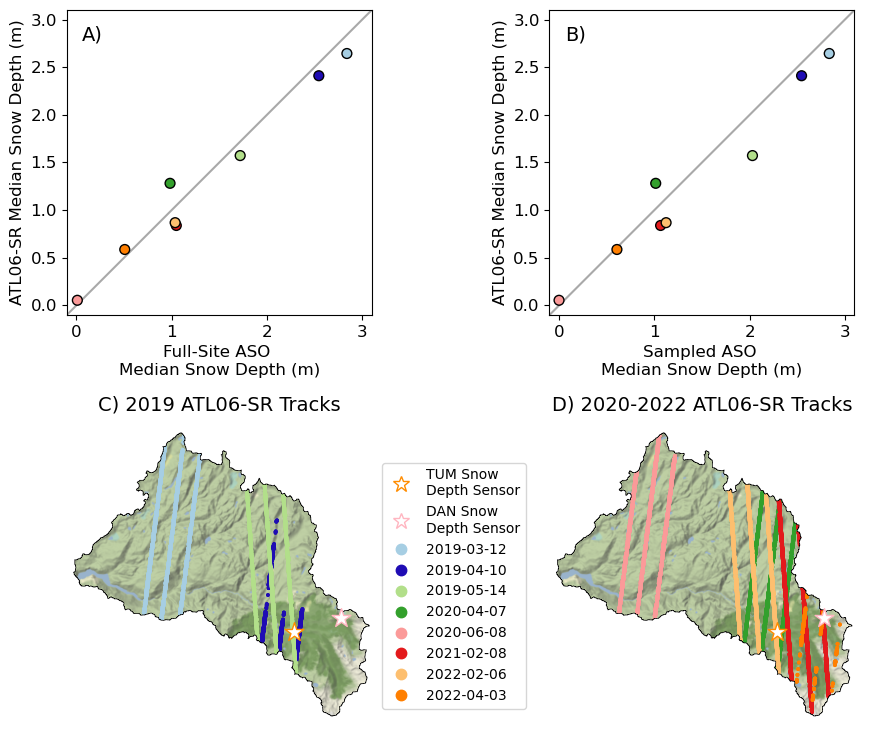

In [78]:
plot_pair_locations(atl06sr_gdf_inner, comp_table, outline_gdf, tuol_reverse, cdec_geom)

In [26]:
from sklearn.metrics import r2_score

aso = comp_table[comp_table['acqdate'].isin(aso_date_list)]['basin_median'] 
atl06sr = comp_table[comp_table['acqdate'].isin(atl06_dates)]['median']

R_square = r2_score(aso, atl06sr)
R_square

In [28]:
aso = comp_table[comp_table['acqdate'].isin(aso_date_list)]['median'] 
atl06sr = comp_table[comp_table['acqdate'].isin(atl06_dates)]['median']

R_square = r2_score(aso, atl06sr)
R_square

0.9427217979332602

In [ ]:
plot_pair_locations(atl06sr_gdf, comp_table, outline_gdf, tuol_reverse, cdec_geom)

In [31]:
comp_table.head(2)

,acqdate,ATL06SR,ASO,pair,median,median_diff,median_track_percent,iqr,iqr_diff,iqr_track_percent,date_offset,tum_depth,dan_depth,delta_tum,delta_dan,basin_median,median_basin_percent,basin_iqr,iqr_basin_percent
2019-03-12,2019-03-12,True,False,0,2.825406,0.155656,NaN,2.909036,-0.312845,NaN,12,2.4892,2.7178,-0.2032,-0.1524,NaN,NaN,NaN,NaN
2019-03-24,2019-03-24,False,True,0,2.981062,0.155656,5.221507,2.596191,-0.312845,-12.05014,12,2.286,2.5654,-0.2032,-0.1524,2.83895,5.482886,1.714828,-18.243507


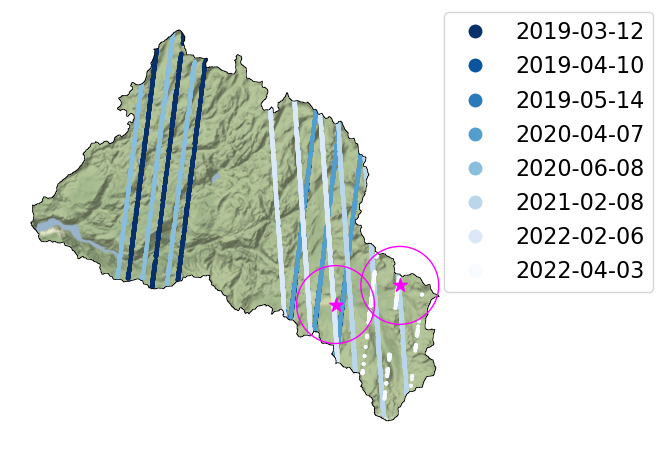

In [58]:
basemap = cx.providers.Stamen.TerrainBackground

fig, ax = plt.subplots()

atl06sr_gdf[atl06sr_gdf['ASO_snowon_date'].isin(aso_date_list)].plot(column='acqdate', cmap='Blues_r', ax=ax, markersize=3, \
                legend=True, legend_kwds={'bbox_to_anchor':(0.94, 1.02)})
outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k')
cx.add_basemap(ax=ax, attribution=False, crs='epsg:32611', source=basemap, zoom=11)
tuol_reverse.plot(ax=ax, facecolor='white')
cdec_geom[0:2].plot(ax=ax, color='magenta', marker='*', markersize=100)
cdec_geom[2:].plot(ax=ax, facecolor='none',edgecolor='magenta')
ax.set_axis_off()
plt.tight_layout()
#plt.savefig('../../figures/date_offset_map.jpeg', dpi=300)

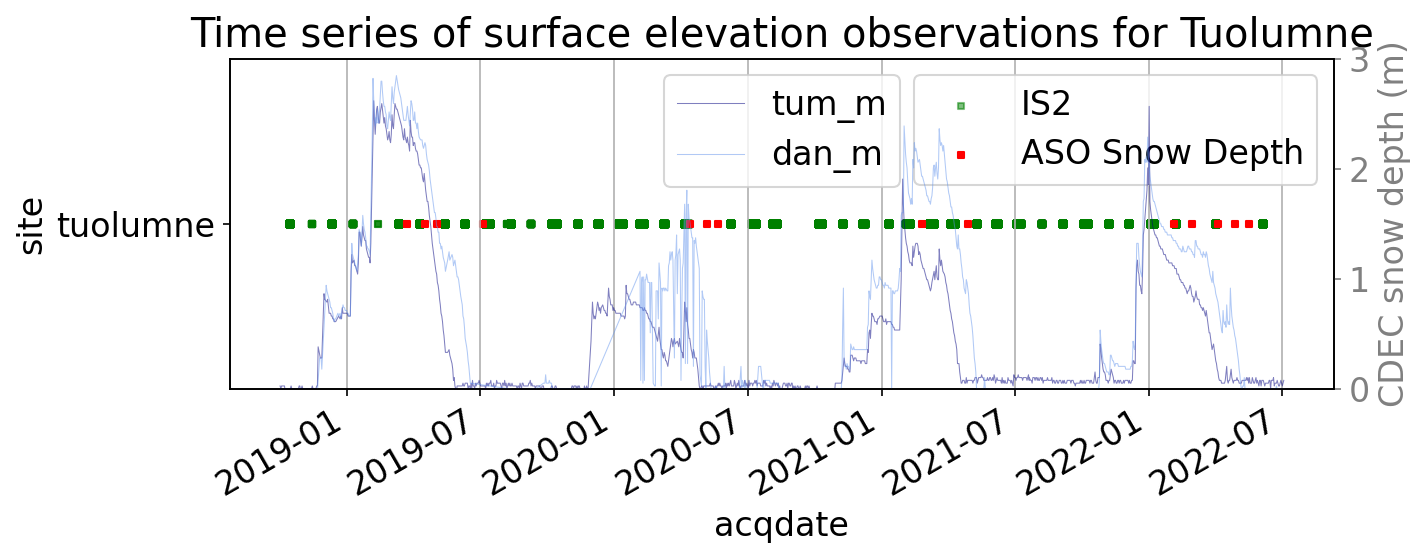

In [211]:
df_list = [aso_gdf, atl06sr_gdf]

f, ax = plt.subplots(figsize=(10,4), dpi=150)
mykw = {'s':10, 'marker':'s', 'kind':'scatter'}

pd.DataFrame(df_list[1].drop(columns='geometry')).plot(ax=ax, alpha=0.5, x='acqdate', y='site', color='g', label='IS2', **mykw)
pd.DataFrame(df_list[0].drop(columns='geometry')).plot(ax=ax, x='acqdate', y='site', color='r', label='ASO Snow Depth', **mykw)

ax1 = ax.twinx()
snwd[snwd['tum_m'] < 2.9]['tum_m'].plot(ax=ax1, alpha=0.5, color='navy', lw=0.5, style='-')
snwd[snwd['dan_m'] < 2.9]['dan_m'].plot(ax=ax1, alpha=0.5, color='cornflowerblue', lw=0.5, style='-')
ax1.set_ylabel('CDEC snow depth (m)', color='gray')
ax1.tick_params(axis='y', colors='gray')
ax1.set_ylim(0,3)
plt.legend(loc='best')

#ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
f.autofmt_xdate()
ax.grid(axis='x', which='major')
ax.set_title('Time series of surface elevation observations for Tuolumne')
plt.tight_layout()
plt.savefig('../../figures/timeseries.jpeg')

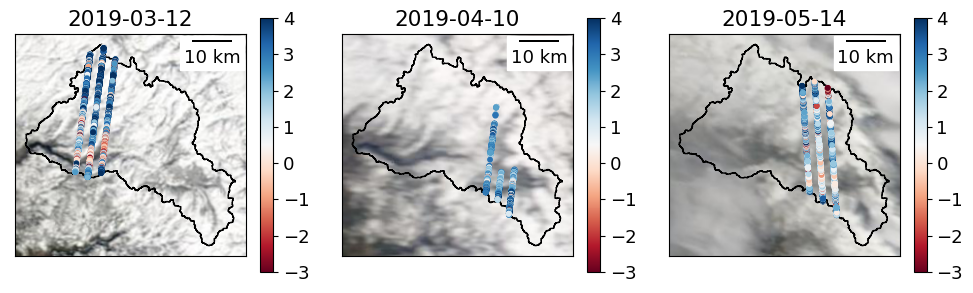

In [34]:
s=10
basemap = cx.providers.NASAGIBS.ModisTerraTrueColorCR
fig, axa = plt.subplots(1,3, figsize=(10,3))

for ax, date in zip(axa, atl06_dates[0:3]):
    outline_gdf.plot(ax=ax, facecolor='none')
    atl06sr_gdf_inner[atl06sr_gdf_inner['acqdate'] == date].plot(ax=ax, column='diff_plus_bicubic', cmap = 'RdBu', legend = True, s=s, vmin = -3, vmax = 4)
    #east5.plot(ax=ax, facecolor='none')
    ax.add_artist(ScaleBar(1))
    basemap.update({'time':date})
    cx.add_basemap(ax, attribution=False, crs=atl06sr_gdf_inner.crs.to_string(), source=basemap, zoom=9)
    ax.set_title(date)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    #plt.colorbar()
    
plt.tight_layout()

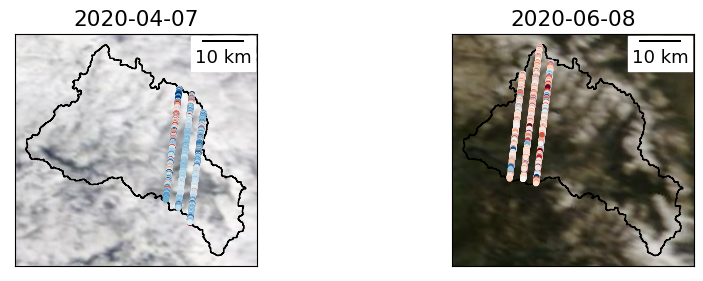

In [21]:
s=10
basemap = cx.providers.NASAGIBS.ModisTerraTrueColorCR
fig, axa = plt.subplots(1,2, figsize=(10,3))

for ax, date in zip(axa, atl06_dates[3:5]):
    outline_gdf.plot(ax=ax, facecolor='none')
    atl06sr_gdf_inner[atl06sr_gdf_inner['acqdate'] == date].plot(ax=ax, column='diff_plus_bicubic', cmap = 'RdBu', legend = False, s=s, vmin = -3, vmax = 4)
    #east5.plot(ax=ax, facecolor='none')
    ax.add_artist(ScaleBar(1))
    basemap.update({'time':date})
    cx.add_basemap(ax, attribution=False, crs=atl06sr_gdf_inner.crs.to_string(), source=basemap, zoom=9)
    ax.set_title(date)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
plt.tight_layout()

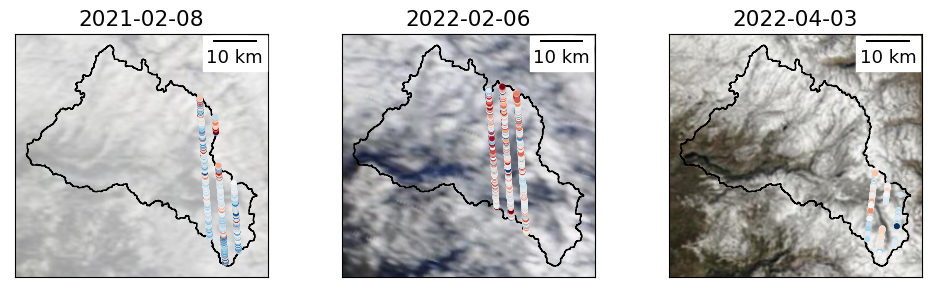

In [25]:
s=10
basemap = cx.providers.NASAGIBS.ModisTerraTrueColorCR
fig, axa = plt.subplots(1,3, figsize=(10,3))

for ax, date in zip(axa, atl06_dates[5:]):
    outline_gdf.plot(ax=ax, facecolor='none')
    atl06sr_gdf_inner[atl06sr_gdf_inner['acqdate'] == date].plot(ax=ax, column='diff_plus_bicubic', cmap = 'RdBu', legend = False, s=s, vmin = -3, vmax = 4)
    #east5.plot(ax=ax, facecolor='none')
    ax.add_artist(ScaleBar(1))
    basemap.update({'time':date})
    cx.add_basemap(ax, attribution=False, crs=atl06sr_gdf_inner.crs.to_string(), source=basemap, zoom=9)
    ax.set_title(date)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
plt.tight_layout()

## Create this table for all ATL06SR Data

In [17]:
def make_comparison_table(df):
    comp_table_all = pd.DataFrame()
    comp_table_all.index = pd.DatetimeIndex(data=df['acqdate'].unique())
    comp_table_all['acqdate'] = comp_table_all.index.date
    # compute the median depth for each ATL06 date
    comp_table_all['median'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'median'] = np.nanmedian(df.loc[df['acqdate']==date,'diff_plus'])
    # compute the iqr for each ATL06 date
    comp_table_all['iqr'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'iqr'] = iqr(df.loc[df['acqdate']==date,'diff_plus'])
    # compute the sample size for each ATL06 date
    comp_table_all['n'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'n'] = df.loc[df['acqdate']==date, 'diff_plus'].count()
    # compute the depth on that day at the tuolumne meadows cdec pillow
    comp_table_all['tum_depth'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'tum_depth'] = snwd[snwd.index == date]['tum_m']
    # compute the depth on that day at the dana meadows cdec pillow
    comp_table_all['dan_depth'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'dan_depth'] = snwd[snwd.index == date]['dan_clean']
    # compute the difference between the atl06 median depth and the depth on that day at the dana meadows snow pillow
    comp_table_all['atl06-dan_diff'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-dan_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'dan_depth']
    # compute the percent difference between the atl06 median depth and dana meadows.
    comp_table_all['atl06-dan_percent'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-dan_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-dan_diff'] / comp_table_all.loc[comp_table_all.index==date,'dan_depth']) * 100
    # compute the difference between the atl06 median depth and the depth on that day at the tuolumne meadows snow pillow    
    comp_table_all['atl06-tum_diff'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-tum_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'tum_depth']
    # compute the percent difference between the atl06 median depth and tuolumne meadows.
    comp_table_all['atl06-tum_percent'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-tum_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-tum_diff'] / comp_table_all.loc[comp_table_all.index==date,'tum_depth']) * 100
    # compute the mean of the tum and dan snow sensors on days with atl06 data
    comp_table_all['cdec_mean'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'cdec_mean'] = (comp_table_all.loc[comp_table_all.index==date,'tum_depth'] + comp_table_all.loc[comp_table_all.index==date,'dan_depth']) / 2
    # compute the percent difference between the atl06sr median depth and the average of the two cdec sites
    comp_table_all['atl06-cdec_mean'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-cdec_mean'] = ((comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'cdec_mean']) / comp_table_all.loc[comp_table_all.index==date,'cdec_mean']) * 100
    comp_table_all['snow_presence'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==pd.Timestamp(date), 'snow_presence'])
    return comp_table_all

In [18]:
comp_df = make_comparison_table(atl06sr_gdf)

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6191/2378598872.py:51: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==pd.Timestamp(date), 'snow_presence'])


In [26]:
comp_df.head()

,acqdate,median,iqr,n,tum_depth,dan_depth,atl06-dan_diff,atl06-dan_percent,atl06-tum_diff,atl06-tum_percent,cdec_mean,atl06-cdec_mean,snow_presence,median_slope20d
2018-10-15,2018-10-15,-0.150095,1.059566,899,0.0,-0.0254,-0.124695,490.926444,-0.150095,-inf,-0.0127,1081.852888,0.0,-0.310401
2018-11-13,2018-11-13,-0.276287,0.362926,17,0.0,-0.0254,-0.250887,987.744826,-0.276287,-inf,-0.0127,2075.489653,0.0,NaN
2018-12-11,2018-12-11,0.477991,1.654234,6115,0.6604,0.7112,-0.233209,-32.790938,-0.182409,-27.62101,0.6858,-30.301713,1.0,0.334288
2019-01-09,2019-01-09,1.24351,1.117565,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.354689
2019-02-12,2019-02-12,2.950302,1.838642,3,NaN,2.413,0.537302,22.266958,NaN,NaN,NaN,NaN,1.0,NaN


In [25]:
comp_df['median_slope20d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_slope20d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']>20),'diff_plus'])


/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6191/3319055117.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_df.loc[comp_df['acqdate']==date, 'median_slope20d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']>20),'diff_plus'])


In [44]:
np.nanmedian(comp_df['median_slope20d'].abs())

0.36266824633617034

In [29]:
np.nanmin(comp_df['median_slope20d'].abs())

0.008490582514241396

In [30]:
np.nanmax(comp_df['median_slope20d'].abs())

2.8022128031559532

In [34]:
comp_df['median_slope10d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_slope10d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']<10),'diff_plus'])


/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6191/1681549759.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_df.loc[comp_df['acqdate']==date, 'median_slope10d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']<10),'diff_plus'])


In [45]:
np.nanmedian(comp_df['median_slope10d'].abs())

0.1826832422661937

In [33]:
np.nanmean(comp_df['median_slope10d'].abs())

0.567243061264421

In [37]:
comp_df['median_slope30t40d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_slope30t40d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']>30) & atl06sr_gdf['slope_20m']<40,'diff_plus'])


/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6191/3317943779.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_df.loc[comp_df['acqdate']==date, 'median_slope30t40d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']>30) & atl06sr_gdf['slope_20m']<40,'diff_plus'])


In [38]:
np.nanmedian(comp_df['median_slope30t40d'].abs())

0.4429990645282942

In [42]:
comp_df['median_slope0t5d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_slope0t5d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']<5),'diff_plus'].abs())


/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6191/4104219318.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_df.loc[comp_df['acqdate']==date, 'median_slope0t5d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']<5),'diff_plus'].abs())


In [46]:
np.nanmedian(comp_df['median_slope0t5d'].abs())

0.3094422645342547

In [22]:
date = comp_df.index[0]
np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']>20),'diff_plus'])

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6191/1865369069.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']>20),'diff_plus'])


-0.3104009530352414

In [59]:
comp_df['median_diff_slope20d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df.index==date, 'median_diff_slope20d'] = (comp_df.loc[comp_table.index==date, 'cdec_mean'] - comp_df.loc[comp_df.index==date, 'median_slope20d'])

IndexError: Boolean index has wrong length: 16 instead of 60

In [57]:
comp_df.head(5)

,acqdate,median,iqr,n,tum_depth,dan_depth,atl06-dan_diff,atl06-dan_percent,atl06-tum_diff,atl06-tum_percent,cdec_mean,atl06-cdec_mean,snow_presence,median_slope20d
2018-10-15,2018-10-15,-0.150095,1.059566,899,0.0,-0.0254,-0.124695,490.926444,-0.150095,-inf,-0.0127,1081.852888,0.0,-0.310401
2018-11-13,2018-11-13,-0.276287,0.362926,17,0.0,-0.0254,-0.250887,987.744826,-0.276287,-inf,-0.0127,2075.489653,0.0,NaN
2018-12-11,2018-12-11,0.477991,1.654234,6115,0.6604,0.7112,-0.233209,-32.790938,-0.182409,-27.62101,0.6858,-30.301713,1.0,0.334288
2019-01-09,2019-01-09,1.24351,1.117565,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.354689
2019-02-12,2019-02-12,2.950302,1.838642,3,NaN,2.413,0.537302,22.266958,NaN,NaN,NaN,NaN,1.0,NaN


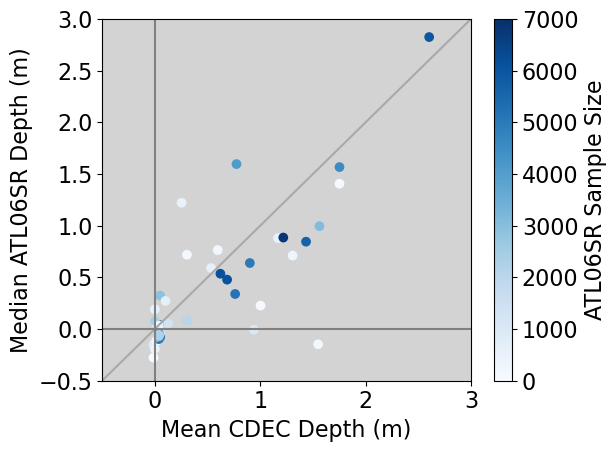

In [165]:
x = np.linspace(-0.7,3,100)
y = x

fig, ax = plt.subplots()
c=plt.scatter(comp_df['cdec_mean'], comp_df['median'], c=comp_df['n'], cmap='Blues', vmin=0, vmax=7000)
plt.plot(x, y, 'darkgrey', label='1:1 line')
plt.axvline(x=0, ymin=(-0.7), ymax=3, color='grey')
plt.axhline(y=0, xmin=(-0.7), xmax=3, color='grey')
plt.colorbar(c, label='ATL06SR Sample Size')
plt.ylim(-0.5, 3)
plt.xlim(-0.5, 3)
plt.xlabel('Mean CDEC Depth (m)')
plt.ylabel('Median ATL06SR Depth (m)')
ax.set_facecolor('lightgrey')
plt.tight_layout()
#plt.savefig('../../figures/polished/median_dif_vs_delta_dan.jpeg', dpi=50

In [450]:
cdec_geom

,geometry,elevation_m,site
0,POINT (293306.562 4194327.335),2621.28,tum
1,POINT (301551.877 4196788.619),2965.00,dan
2,"POLYGON ((298306.562 4194327.335, 298282.486 4...",NaN,tum_5km
3,"POLYGON ((306551.877 4196788.619, 306527.800 4...",NaN,dan_5km


In [256]:
comp_tumradius = make_comparison_table(atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[2, 'geometry'])])

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_38727/2378598872.py:51: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==pd.Timestamp(date), 'snow_presence'])


In [257]:
comp_danradius = make_comparison_table(atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[3, 'geometry'])])

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_38727/2378598872.py:51: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==pd.Timestamp(date), 'snow_presence'])


In [258]:
comp_tumradius = comp_tumradius.drop(columns=['dan_depth', 'atl06-dan_diff', 'atl06-dan_percent'])

In [259]:
comp_danradius = comp_danradius.drop(columns=['tum_depth', 'atl06-tum_diff', 'atl06-tum_percent'])

In [171]:
comp_tumradius.to_csv('../../figures/comp_tumradius.csv')
comp_danradius.to_csv('../../figures/comp_danradius.csv')

In [287]:
for data in [(comp_df[comp_df['snow_presence']==1]['iqr']), comp_df[comp_df['snow_presence']==1]['atl06-tum_diff'], \
             comp_df[comp_df['snow_presence']==1]['atl06-tum_percent'], comp_df[comp_df['snow_presence']==1]['atl06-dan_diff'], \
            comp_df[comp_df['snow_presence']==1]['atl06-dan_percent'], comp_tumradius[comp_tumradius['snow_presence']==1]['iqr'], \
            comp_tumradius[comp_tumradius['snow_presence']==1]['atl06-tum_diff'], comp_tumradius[comp_tumradius['snow_presence']==1]['atl06-tum_percent'], \
            comp_danradius[comp_danradius['snow_presence']==1]['atl06-dan_diff'], comp_danradius[comp_danradius['snow_presence']==1]['atl06-dan_percent'], \
            comp_danradius[comp_danradius['snow_presence']==1]['iqr']]:
    print(f'{data.name}', 'median =', np.nanmedian(data.abs()))

iqr median = 1.2492877224473204
atl06-tum_diff median = 0.21461617015184203
atl06-tum_percent median = 28.5410215215685
atl06-dan_diff median = 0.45702322967205566
atl06-dan_percent median = 41.48752070510733
iqr median = 0.7031003418849195
atl06-tum_diff median = 0.1799892255039115
atl06-tum_percent median = 22.81320125627248
atl06-dan_diff median = 0.543928369211129
atl06-dan_percent median = 44.87084964894188
iqr median = 0.7449141811357549


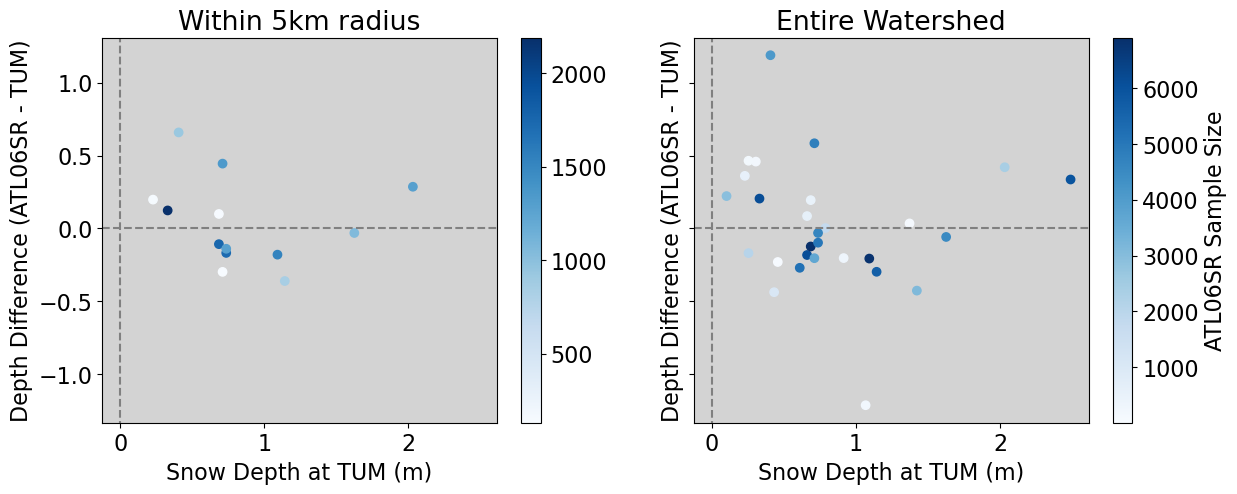

In [260]:
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True, sharex=True)
#c = plt.scatter(comp_tumradius['tum_depth'], comp_tumradius['atl06-tum_diff'], c=comp_tumradius['n'], cmap='Blues')
c1 = ax[0].scatter(comp_tumradius[comp_tumradius['snow_presence']==1]['tum_depth'], comp_tumradius[comp_tumradius['snow_presence']==1]['atl06-tum_diff'], c=comp_tumradius[comp_tumradius['snow_presence']==1]['n'], cmap='Blues') # , linewidth=0, marker='.'
ax[0].set_xlabel('Snow Depth at TUM (m)')
ax[0].set_ylabel('Depth Difference (ATL06SR - TUM)')
ax[0].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
ax[0].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[0].set_title('Within 5km radius')
ax[0].set_facecolor('lightgrey')
fig.colorbar(c1, ax=ax[0])

c = ax[1].scatter(comp_df[comp_df['snow_presence']==1]['tum_depth'], comp_df[comp_df['snow_presence']==1]['atl06-tum_diff'], c=comp_df[comp_df['snow_presence']==1]['n'], cmap='Blues')
ax[1].set_xlabel('Snow Depth at TUM (m)')
ax[1].set_ylabel('Depth Difference (ATL06SR - TUM)')
ax[1].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
ax[1].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[1].set_title('Entire Watershed')
ax[1].set_facecolor('lightgrey')
fig.colorbar(c, ax=ax[1], label='ATL06SR Sample Size')

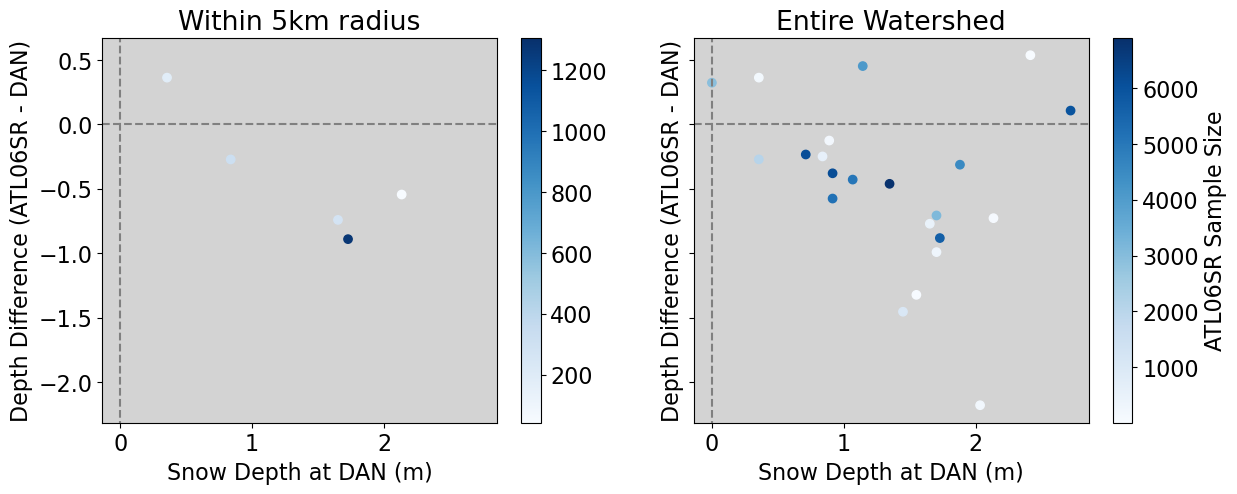

In [261]:
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True, sharex=True)
#c = plt.scatter(comp_tumradius['tum_depth'], comp_tumradius['atl06-tum_diff'], c=comp_tumradius['n'], cmap='Blues')
c1 = ax[0].scatter(comp_danradius[comp_danradius['snow_presence']==1]['dan_depth'], comp_danradius[comp_danradius['snow_presence']==1]['atl06-dan_diff'], c=comp_danradius[comp_danradius['snow_presence']==1]['n'], cmap='Blues') # , linewidth=0, marker='.'
ax[0].set_xlabel('Snow Depth at DAN (m)')
ax[0].set_ylabel('Depth Difference (ATL06SR - DAN)')
ax[0].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
ax[0].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[0].set_title('Within 5km radius')
ax[0].set_facecolor('lightgrey')
fig.colorbar(c1, ax=ax[0])

c = ax[1].scatter(comp_df[comp_df['snow_presence']==1]['dan_depth'], comp_df[comp_df['snow_presence']==1]['atl06-dan_diff'], c=comp_df[comp_df['snow_presence']==1]['n'], cmap='Blues')
ax[1].set_xlabel('Snow Depth at DAN (m)')
ax[1].set_ylabel('Depth Difference (ATL06SR - DAN)')
ax[1].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
ax[1].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[1].set_title('Entire Watershed')
ax[1].set_facecolor('lightgrey')
fig.colorbar(c, ax=ax[1], label='ATL06SR Sample Size')

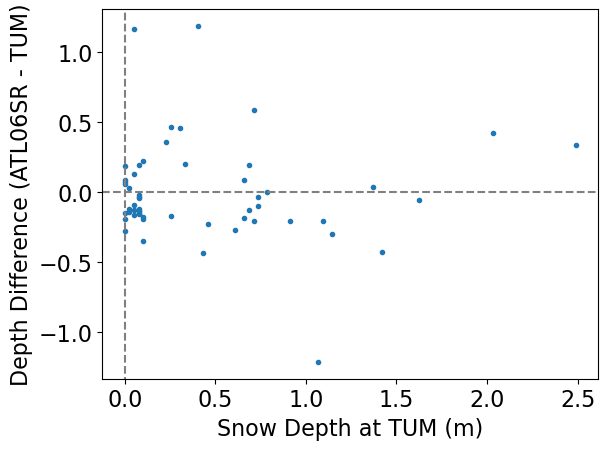

In [193]:
fig, ax = plt.subplots()
plt.plot(comp_df['tum_depth'], comp_df['atl06-tum_diff'], linewidth=0, marker='.')
plt.xlabel('Snow Depth at TUM (m)')
plt.ylabel('Depth Difference (ATL06SR - TUM)')
plt.axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
plt.axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


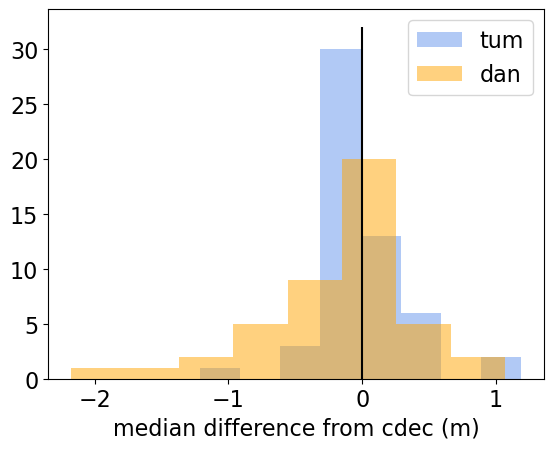

In [326]:
fig, ax = plt.subplots()
plt.hist(comp_table_all['atl06-tum_diff'], bins=round(np.sqrt(len(comp_table_all))), label='tum', alpha=0.5, color='cornflowerblue')
plt.hist(comp_table_all['atl06-dan_diff'], bins=round(np.sqrt(len(comp_table_all))), label='dan', alpha=0.5, color='orange')
plt.vlines(x=0, ymin=0, ymax=32, color='k')
plt.xlabel('median difference from cdec (m)')
#plt.ylabel('difference between \nATL06SR and CDEC')
plt.legend()

In [181]:
print('Median of the median differences between ATL06SR and DAN:', np.nanmedian(comp_table_all['atl06-dan_diff']))
print('Median of the median differences between ATL06SR and TUM:', np.nanmedian(comp_table_all['atl06-tum_diff']))

Median of the median differences between ATL06SR and DAN: -0.11778255058343248
Median of the median differences between ATL06SR and TUM: -0.09398747191903567
